In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

2.3.0+cu121


In [ ]:
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q pyg_lib -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 12.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from torch_geometric.nn import Node2Vec
import os.path as osp
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.datasets import Planetoid
from tqdm.notebook import tqdm

In [ ]:
import torch_geometric.transforms as T
from torch_geometric.datasets import ShapeNet

dataset = ShapeNet(root='/tmp/ShapeNet', categories=['Airplane'],
                    pre_transform=T.KNNGraph(k=6))

data=dataset[0]

In [ ]:
data

Data(x=[2518, 3], y=[2518], pos=[2518, 3], category=[1], edge_index=[2, 15108])

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Node2Vec(data.edge_index, embedding_dim=128,
                 walk_length=20,                        # lenght of rw
                 context_size=10, walks_per_node=20,
                 num_negative_samples=1,
                 p=200, q=1,                             # bias parameters
                 sparse=True).to(device)

In [ ]:
loader = model.loader(batch_size=128, shuffle=True, num_workers=4)

In [ ]:
for idx, (pos_rw, neg_rw) in enumerate(loader):
    print(idx, pos_rw.shape, neg_rw.shape)

0 torch.Size([28160, 10]) torch.Size([28160, 10])
1 torch.Size([28160, 10]) torch.Size([28160, 10])
2 torch.Size([28160, 10]) torch.Size([28160, 10])
3 torch.Size([28160, 10]) torch.Size([28160, 10])
4 torch.Size([28160, 10]) torch.Size([28160, 10])
5 torch.Size([28160, 10]) torch.Size([28160, 10])
6 torch.Size([28160, 10]) torch.Size([28160, 10])
7 torch.Size([28160, 10]) torch.Size([28160, 10])
8 torch.Size([28160, 10]) torch.Size([28160, 10])
9 torch.Size([28160, 10]) torch.Size([28160, 10])
10 torch.Size([28160, 10]) torch.Size([28160, 10])
11 torch.Size([28160, 10]) torch.Size([28160, 10])
12 torch.Size([28160, 10]) torch.Size([28160, 10])
13 torch.Size([28160, 10]) torch.Size([28160, 10])
14 torch.Size([28160, 10]) torch.Size([28160, 10])
15 torch.Size([28160, 10]) torch.Size([28160, 10])
16 torch.Size([28160, 10]) torch.Size([28160, 10])
17 torch.Size([28160, 10]) torch.Size([28160, 10])
18 torch.Size([28160, 10]) torch.Size([28160, 10])
19 torch.Size([18920, 10]) torch.Size([18

In [ ]:
idx, (pos_rw, neg_rw) = next(enumerate(loader))

In [ ]:
(pos_rw.shape, neg_rw.shape)

(torch.Size([28160, 10]), torch.Size([28160, 10]))

In [ ]:
import networkx as nx
edge_tuples = [tuple(x) for x in data.edge_index.numpy().transpose()]
G = nx.from_edgelist(edge_tuples)
pos = nx.spring_layout(G, center=[0.5, 0.5])
nx.set_node_attributes(G, pos, 'pos')

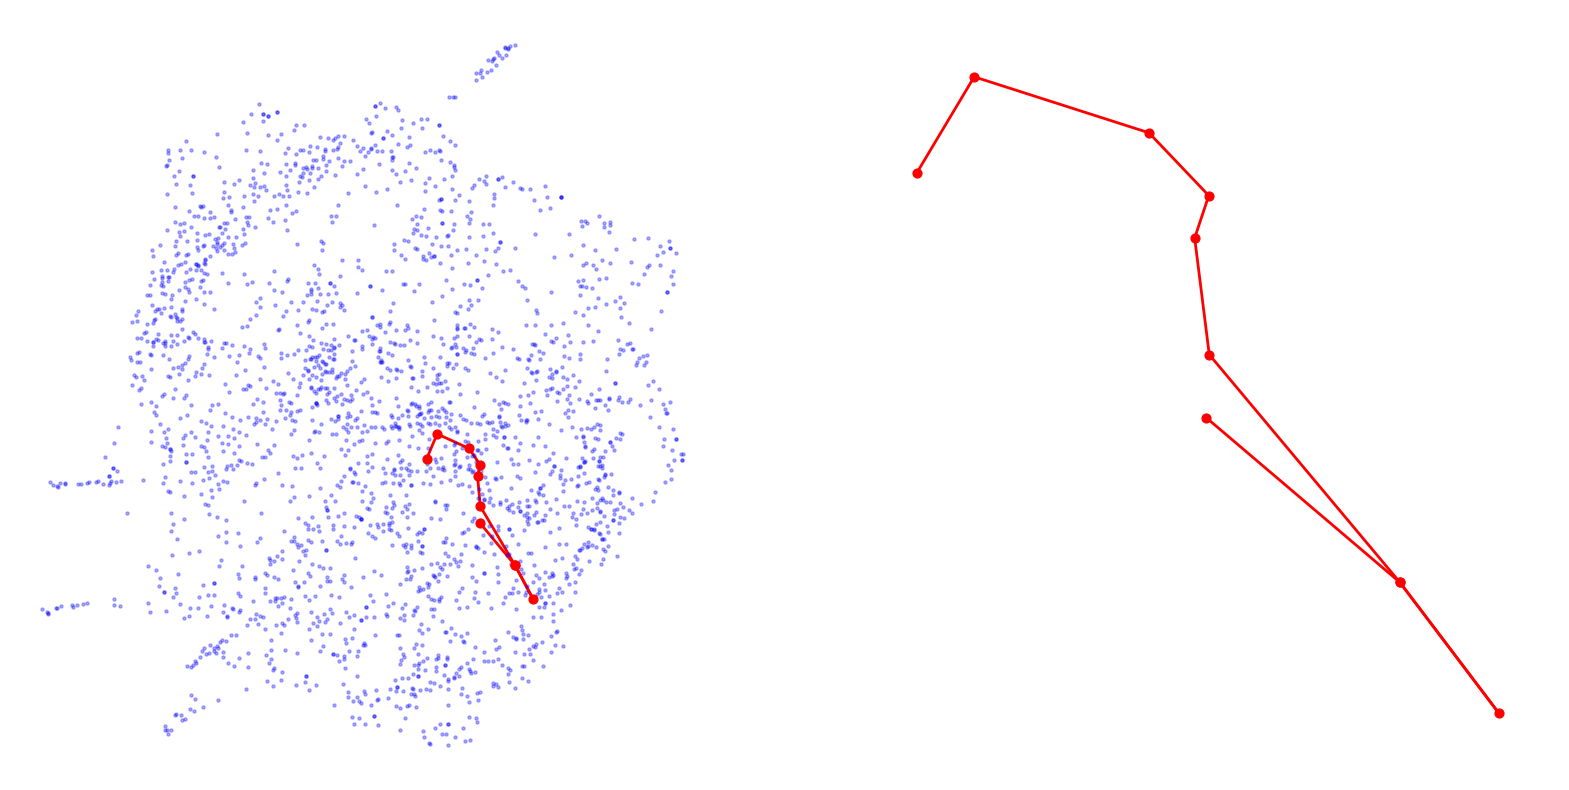

In [ ]:
nodelist = next(enumerate(loader))[1][0][0].tolist()
walk = nx.path_graph(len(nodelist))
nx.set_node_attributes(walk, {idx: pos[node_id] for idx, node_id in enumerate(nodelist)}, 'pos')

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 2, 1)
nx.draw_networkx_nodes(G,
                       ax=ax,
                       pos=nx.get_node_attributes(G, 'pos'),
                       node_size=5,
                       alpha=0.3,
                       node_color='b')
nx.draw(walk,
        node_size=40,
        node_color='r',
        ax=ax,
        pos=nx.get_node_attributes(walk, 'pos'),
        width=2,
        edge_color='r')
ax = fig.add_subplot(1, 2, 2)
nx.draw(walk,
        node_size=40,
        node_color='r',
        ax=ax,
        pos=nx.get_node_attributes(walk, 'pos'),
        width=2,
        edge_color='r')

In [ ]:
model = Node2Vec(data.edge_index, embedding_dim=128, walk_length=20,
                 context_size=10, walks_per_node=10,
                 num_negative_samples=1, p=1, q=1, sparse=True).to(device)

loader = model.loader(batch_size=128, shuffle=True, num_workers=4)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

In [ ]:
def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in tqdm(loader):
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

In [ ]:
data

Data(x=[2518, 3], y=[2518], pos=[2518, 3], category=[1], edge_index=[2, 15108])

In [ ]:
data

Data(x=[2518, 3], y=[2518], pos=[2518, 3], category=[1], edge_index=[2, 15108], train_mask=[2518, 128], dev_mask=[2518, 128], test_mask=[2518, 128])

In [ ]:
data.y

tensor([0, 0, 3,  ..., 3, 1, 1])

In [ ]:
data.y.unique()

tensor([0, 1, 2, 3])

In [ ]:
@torch.no_grad()
def test():
    model.eval()
    z = model()
    print(z)
    print(f"Shape of z: {z.shape}")

    acc = model.test(z[data.train_mask], data.y[data.train_mask],
                     z[data.test_mask], data.y[data.test_mask],
                     max_iter=150)
    return acc

In [ ]:
import numpy as np

In [ ]:
d= data

In [ ]:
data= d

In [ ]:
data

Data(x=[2518, 3], y=[2518], pos=[2518, 3], category=[1], edge_index=[2, 15108])

In [ ]:
def create_masks(data):
    """
    Splits data into training, validation, and test splits in a stratified manner if
    it is not already splitted. Each split is associated with a mask vector, which
    specifies the indices for that split. The data will be modified in-place
    :param data: Data object
    :return: The modified data
    """
    if not hasattr(data, "val_mask"):
        data.train_mask = data.dev_mask = data.test_mask = None

        labels = data.y.numpy()
        dev_size = int(labels.shape[0] * 0.1)
        test_size = int(labels.shape[0] * 0.8)

        perm = np.random.permutation(labels.shape[0])
        test_index = perm[:test_size]
        dev_index = perm[test_size:test_size + dev_size]

        data_index = np.arange(labels.shape[0])
        test_mask = torch.tensor(np.in1d(data_index, test_index), dtype=torch.bool)
        dev_mask = torch.tensor(np.in1d(data_index, dev_index), dtype=torch.bool)
        train_mask = ~(dev_mask + test_mask)

        data.train_mask = train_mask
        data.val_mask = dev_mask
        data.test_mask = test_mask

        # Reshape masks to match the shape of y
        data.train_mask = data.train_mask.view(-1)
        data.val_mask = data.val_mask.view(-1)
        data.test_mask = data.test_mask.view(-1)

    return data


In [ ]:
data = create_masks(data)

In [ ]:
data

Data(x=[2518, 3], y=[2518], pos=[2518, 3], category=[1], edge_index=[2, 15108], train_mask=[2518], val_mask=[2518], test_mask=[2518])

In [ ]:
data

Data(x=[2518, 3], y=[2518], pos=[2518, 3], category=[1], edge_index=[2, 15108], train_mask=[2518, 20], dev_mask=[2518, 20], test_mask=[2518, 20])

### Training

In [ ]:
for epoch in range(1, 201):
    loss = train()
    acc = test()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Acc: {acc:.4f}')

  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[ 0.2869,  1.0542,  1.4895,  ...,  0.0569, -0.9591, -0.1731],
        [-0.2724,  1.4676, -1.3334,  ..., -0.1161, -1.2966, -0.8075],
        [ 0.4864,  0.2231,  0.9238,  ..., -0.7894,  0.0542,  0.8432],
        ...,
        [-0.0081, -1.1764, -0.3927,  ...,  0.8336,  0.2236, -0.1669],
        [ 0.4393, -0.4353, -0.2575,  ..., -1.4553,  1.5641, -0.3236],
        [ 0.9467, -0.4240,  0.2021,  ...,  1.3044,  1.5225,  0.0458]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 01, Loss: 4.0396, Acc: 0.4374


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[ 0.2780,  1.0285,  1.4298,  ...,  0.0491, -0.9550, -0.1459],
        [-0.2884,  1.3709, -1.2865,  ..., -0.1613, -1.2490, -0.8070],
        [ 0.4364,  0.2485,  0.8459,  ..., -0.7309,  0.0284,  0.7685],
        ...,
        [-0.0117, -1.0974, -0.3489,  ...,  0.7778,  0.2469, -0.0800],
        [ 0.4527, -0.3838, -0.2626,  ..., -1.3228,  1.4933, -0.2668],
        [ 0.9026, -0.3958,  0.1898,  ...,  1.2639,  1.4663,  0.0535]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 02, Loss: 3.4597, Acc: 0.4508


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[ 0.2674,  0.9835,  1.3298,  ...,  0.0310, -0.9520, -0.1342],
        [-0.3046,  1.3001, -1.2528,  ..., -0.1685, -1.2133, -0.7938],
        [ 0.3521,  0.2731,  0.7355,  ..., -0.6651,  0.0285,  0.7061],
        ...,
        [ 0.0256, -0.9819, -0.3287,  ...,  0.7168,  0.2642, -0.0575],
        [ 0.4248, -0.3188, -0.2361,  ..., -1.2207,  1.4280, -0.2142],
        [ 0.8667, -0.4307,  0.1761,  ...,  1.2091,  1.4164,  0.0404]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 03, Loss: 2.9840, Acc: 0.4603


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[ 0.2509,  0.9129,  1.2511,  ...,  0.0361, -0.9304, -0.1189],
        [-0.2912,  1.2217, -1.2087,  ..., -0.1960, -1.1754, -0.7661],
        [ 0.2956,  0.2643,  0.6449,  ..., -0.6279,  0.0322,  0.6396],
        ...,
        [ 0.0450, -0.8509, -0.3196,  ...,  0.6639,  0.2715, -0.0092],
        [ 0.4024, -0.2449, -0.2226,  ..., -1.1359,  1.3244, -0.1985],
        [ 0.8310, -0.4327,  0.1695,  ...,  1.1762,  1.3586,  0.0252]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 04, Loss: 2.5956, Acc: 0.4757


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[ 2.1004e-01,  8.5780e-01,  1.1945e+00,  ...,  5.2626e-02,
         -8.9965e-01, -1.2339e-01],
        [-2.7170e-01,  1.1446e+00, -1.1623e+00,  ..., -2.2288e-01,
         -1.1135e+00, -7.3129e-01],
        [ 2.5252e-01,  2.9329e-01,  5.8739e-01,  ..., -5.5891e-01,
         -3.2787e-02,  5.6861e-01],
        ...,
        [ 3.4319e-02, -7.4734e-01, -2.9192e-01,  ...,  6.2074e-01,
          2.6665e-01, -1.0552e-04],
        [ 3.6859e-01, -2.1113e-01, -2.3108e-01,  ..., -1.0496e+00,
          1.2307e+00, -1.8653e-01],
        [ 7.9022e-01, -4.2641e-01,  1.5638e-01,  ...,  1.1449e+00,
          1.2942e+00,  1.9381e-02]], requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 05, Loss: 2.2762, Acc: 0.4896


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[ 0.1874,  0.8153,  1.1715,  ...,  0.0601, -0.8796, -0.1350],
        [-0.2703,  1.0718, -1.1009,  ..., -0.2252, -1.0714, -0.6727],
        [ 0.2120,  0.2795,  0.5452,  ..., -0.5101, -0.0748,  0.5031],
        ...,
        [ 0.0345, -0.6650, -0.2752,  ...,  0.5789,  0.2946,  0.0073],
        [ 0.3352, -0.1707, -0.2034,  ..., -0.9846,  1.1494, -0.1449],
        [ 0.7571, -0.4063,  0.1985,  ...,  1.0898,  1.2247,  0.0223]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 06, Loss: 2.0090, Acc: 0.4995


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[ 0.1770,  0.7952,  1.1227,  ...,  0.0714, -0.8503, -0.1263],
        [-0.2622,  1.0120, -1.0416,  ..., -0.2205, -1.0185, -0.6220],
        [ 0.1682,  0.2624,  0.5178,  ..., -0.4293, -0.0888,  0.4375],
        ...,
        [ 0.0543, -0.5847, -0.2331,  ...,  0.5255,  0.2699,  0.0262],
        [ 0.2898, -0.1390, -0.1591,  ..., -0.9145,  1.0862, -0.1116],
        [ 0.7254, -0.3641,  0.1880,  ...,  1.0480,  1.1491,  0.0209]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 07, Loss: 1.7880, Acc: 0.5209


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[ 0.1682,  0.7618,  1.0662,  ...,  0.0908, -0.8333, -0.1245],
        [-0.2114,  0.9546, -1.0040,  ..., -0.2281, -0.9806, -0.5931],
        [ 0.1390,  0.2804,  0.4846,  ..., -0.3700, -0.0853,  0.3818],
        ...,
        [ 0.0620, -0.5314, -0.1911,  ...,  0.4683,  0.2317,  0.0477],
        [ 0.2756, -0.1186, -0.1183,  ..., -0.8139,  1.0045, -0.1304],
        [ 0.7063, -0.3394,  0.1528,  ...,  1.0055,  1.0856,  0.0275]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 08, Loss: 1.6072, Acc: 0.5427


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[ 0.1468,  0.7247,  0.9911,  ...,  0.0950, -0.8133, -0.1325],
        [-0.2004,  0.9188, -0.9496,  ..., -0.2328, -0.9458, -0.5646],
        [ 0.1190,  0.2276,  0.4446,  ..., -0.3507, -0.0831,  0.3316],
        ...,
        [ 0.0737, -0.4754, -0.1956,  ...,  0.4307,  0.2265,  0.0549],
        [ 0.2487, -0.0969, -0.1091,  ..., -0.7388,  0.9412, -0.1262],
        [ 0.6837, -0.3274,  0.1223,  ...,  0.9708,  1.0117,  0.0194]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 09, Loss: 1.4604, Acc: 0.5566


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[ 0.1271,  0.6959,  0.9453,  ...,  0.1043, -0.8189, -0.1336],
        [-0.1939,  0.8761, -0.8944,  ..., -0.2127, -0.8934, -0.5406],
        [ 0.0858,  0.1998,  0.3980,  ..., -0.3368, -0.1140,  0.2925],
        ...,
        [ 0.1011, -0.4161, -0.1804,  ...,  0.3990,  0.2380,  0.0441],
        [ 0.2336, -0.0531, -0.1164,  ..., -0.6861,  0.8858, -0.1159],
        [ 0.6611, -0.3151,  0.0993,  ...,  0.9232,  0.9542,  0.0306]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 10, Loss: 1.3361, Acc: 0.5785


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[ 0.1009,  0.6683,  0.8863,  ...,  0.1233, -0.8058, -0.1273],
        [-0.2156,  0.8407, -0.8380,  ..., -0.1966, -0.8450, -0.4997],
        [ 0.0704,  0.1570,  0.3538,  ..., -0.3295, -0.1470,  0.2458],
        ...,
        [ 0.0921, -0.3721, -0.1821,  ...,  0.3546,  0.2292,  0.0611],
        [ 0.2166,  0.0029, -0.1046,  ..., -0.6259,  0.8300, -0.0909],
        [ 0.6375, -0.2785,  0.0750,  ...,  0.8688,  0.9127,  0.0285]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 11, Loss: 1.2383, Acc: 0.6013


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[ 0.0738,  0.6410,  0.8247,  ...,  0.1110, -0.7882, -0.1376],
        [-0.1974,  0.7990, -0.7977,  ..., -0.1686, -0.8209, -0.4662],
        [ 0.0572,  0.1324,  0.3304,  ..., -0.3138, -0.1698,  0.2141],
        ...,
        [ 0.0961, -0.3263, -0.1775,  ...,  0.3150,  0.2064,  0.0724],
        [ 0.2176,  0.0205, -0.1036,  ..., -0.5695,  0.7918, -0.0710],
        [ 0.6122, -0.2448,  0.0264,  ...,  0.8321,  0.8797,  0.0378]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 12, Loss: 1.1567, Acc: 0.6271


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[ 0.0377,  0.6309,  0.8004,  ...,  0.0766, -0.7680, -0.1215],
        [-0.1596,  0.7412, -0.7455,  ..., -0.1586, -0.7764, -0.4247],
        [ 0.0677,  0.1468,  0.3126,  ..., -0.3297, -0.1702,  0.1816],
        ...,
        [ 0.0894, -0.2847, -0.1687,  ...,  0.2895,  0.1944,  0.0852],
        [ 0.2235,  0.0203, -0.0887,  ..., -0.5218,  0.7508, -0.0818],
        [ 0.5938, -0.2196, -0.0042,  ...,  0.7920,  0.8531,  0.0605]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 13, Loss: 1.0879, Acc: 0.6544


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[ 0.0045,  0.5854,  0.7709,  ...,  0.0674, -0.7614, -0.1224],
        [-0.1392,  0.7019, -0.7068,  ..., -0.1583, -0.7373, -0.3839],
        [ 0.0651,  0.1394,  0.2993,  ..., -0.3343, -0.1970,  0.1541],
        ...,
        [ 0.0999, -0.2746, -0.1604,  ...,  0.2741,  0.1662,  0.0783],
        [ 0.2400,  0.0255, -0.0746,  ..., -0.4521,  0.7081, -0.0647],
        [ 0.5740, -0.1960, -0.0225,  ...,  0.7448,  0.8188,  0.0720]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 14, Loss: 1.0334, Acc: 0.6792


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.0032,  0.5486,  0.7441,  ...,  0.0382, -0.7547, -0.1197],
        [-0.1375,  0.6597, -0.6714,  ..., -0.1569, -0.6796, -0.3316],
        [ 0.0731,  0.1364,  0.2846,  ..., -0.3349, -0.2001,  0.1250],
        ...,
        [ 0.1019, -0.2467, -0.1647,  ...,  0.2557,  0.1272,  0.0856],
        [ 0.2188,  0.0286, -0.0704,  ..., -0.4042,  0.6633, -0.0662],
        [ 0.5578, -0.2043, -0.0025,  ...,  0.6978,  0.7816,  0.0832]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 15, Loss: 0.9900, Acc: 0.7001


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.0197,  0.5375,  0.6897,  ...,  0.0351, -0.7446, -0.0972],
        [-0.1286,  0.6271, -0.6425,  ..., -0.1458, -0.6351, -0.3216],
        [ 0.0684,  0.1141,  0.2680,  ..., -0.3267, -0.1901,  0.0956],
        ...,
        [ 0.0837, -0.1800, -0.1719,  ...,  0.2235,  0.1456,  0.0757],
        [ 0.2421,  0.0018, -0.0512,  ..., -0.3619,  0.6261, -0.0656],
        [ 0.5451, -0.1975, -0.0020,  ...,  0.6684,  0.7526,  0.0785]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 16, Loss: 0.9543, Acc: 0.7294


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.0207,  0.5300,  0.6351,  ...,  0.0336, -0.7373, -0.0999],
        [-0.1316,  0.6011, -0.6337,  ..., -0.1358, -0.5836, -0.3102],
        [ 0.0674,  0.0822,  0.2359,  ..., -0.3164, -0.1851,  0.0559],
        ...,
        [ 0.0458, -0.1474, -0.1751,  ...,  0.1970,  0.1383,  0.1005],
        [ 0.2411, -0.0100, -0.0216,  ..., -0.3088,  0.5941, -0.0315],
        [ 0.5296, -0.1959,  0.0008,  ...,  0.6375,  0.7307,  0.0693]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 17, Loss: 0.9242, Acc: 0.7547


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.0346,  0.5273,  0.6024,  ...,  0.0394, -0.7194, -0.1163],
        [-0.1313,  0.5737, -0.6186,  ..., -0.1044, -0.5490, -0.2991],
        [ 0.0896,  0.0465,  0.2011,  ..., -0.3023, -0.1960,  0.0240],
        ...,
        [ 0.0372, -0.1418, -0.1929,  ...,  0.1723,  0.1225,  0.1131],
        [ 0.2428, -0.0268, -0.0046,  ..., -0.2772,  0.5588, -0.0241],
        [ 0.5179, -0.1957,  0.0081,  ...,  0.6042,  0.7079,  0.0874]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 18, Loss: 0.8994, Acc: 0.7820


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.0555,  0.5170,  0.5870,  ...,  0.0388, -0.7157, -0.1177],
        [-0.1191,  0.5554, -0.5870,  ..., -0.0901, -0.5233, -0.2836],
        [ 0.1076,  0.0236,  0.1916,  ..., -0.2940, -0.2120,  0.0037],
        ...,
        [ 0.0195, -0.1154, -0.1965,  ...,  0.1535,  0.1270,  0.1038],
        [ 0.2531, -0.0378,  0.0110,  ..., -0.2413,  0.5309, -0.0137],
        [ 0.5168, -0.1933,  0.0098,  ...,  0.5806,  0.6858,  0.0926]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 19, Loss: 0.8791, Acc: 0.8034


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.0672,  0.5133,  0.5746,  ...,  0.0386, -0.7182, -0.1126],
        [-0.0980,  0.5154, -0.5586,  ..., -0.0730, -0.4895, -0.2755],
        [ 0.1064,  0.0195,  0.1918,  ..., -0.2829, -0.2317, -0.0185],
        ...,
        [ 0.0250, -0.0924, -0.1989,  ...,  0.1360,  0.1257,  0.1200],
        [ 0.2620, -0.0715,  0.0368,  ..., -0.2089,  0.5101, -0.0011],
        [ 0.4987, -0.1829,  0.0013,  ...,  0.5664,  0.6627,  0.1009]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 20, Loss: 0.8622, Acc: 0.8217


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.0723,  0.4874,  0.5665,  ...,  0.0252, -0.7159, -0.1280],
        [-0.0761,  0.4760, -0.5390,  ..., -0.0399, -0.4560, -0.2635],
        [ 0.1170, -0.0042,  0.1952,  ..., -0.2949, -0.2231, -0.0273],
        ...,
        [ 0.0039, -0.0755, -0.1967,  ...,  0.1101,  0.1179,  0.1274],
        [ 0.2472, -0.0889,  0.0498,  ..., -0.1787,  0.4870,  0.0116],
        [ 0.4927, -0.1588, -0.0207,  ...,  0.5496,  0.6415,  0.1136]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 21, Loss: 0.8479, Acc: 0.8381


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.0769,  0.4851,  0.5511,  ...,  0.0263, -0.7044, -0.1359],
        [-0.0687,  0.4510, -0.5407,  ..., -0.0231, -0.4132, -0.2472],
        [ 0.1406, -0.0254,  0.1804,  ..., -0.3185, -0.2198, -0.0517],
        ...,
        [-0.0054, -0.0740, -0.1880,  ...,  0.0879,  0.1157,  0.1298],
        [ 0.2443, -0.0793,  0.0504,  ..., -0.1624,  0.4572,  0.0216],
        [ 0.4887, -0.1540, -0.0302,  ...,  0.5328,  0.6120,  0.0984]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 22, Loss: 0.8368, Acc: 0.8535


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.0873,  0.4871,  0.5381,  ...,  0.0149, -0.6926, -0.1450],
        [-0.0609,  0.4366, -0.5274,  ..., -0.0082, -0.3846, -0.2278],
        [ 0.1324, -0.0283,  0.1682,  ..., -0.3208, -0.2023, -0.0750],
        ...,
        [-0.0099, -0.0721, -0.1846,  ...,  0.0648,  0.1190,  0.1191],
        [ 0.2331, -0.0798,  0.0502,  ..., -0.1294,  0.4381,  0.0336],
        [ 0.4876, -0.1494, -0.0157,  ...,  0.5079,  0.5852,  0.0869]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 23, Loss: 0.8266, Acc: 0.8644


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.1064,  0.4826,  0.5324,  ...,  0.0047, -0.6870, -0.1332],
        [-0.0519,  0.4326, -0.4947,  ..., -0.0059, -0.3546, -0.2125],
        [ 0.1039, -0.0056,  0.1692,  ..., -0.3278, -0.2143, -0.0883],
        ...,
        [ 0.0017, -0.0590, -0.1885,  ...,  0.0575,  0.1239,  0.0976],
        [ 0.2511, -0.0710,  0.0366,  ..., -0.1018,  0.4282,  0.0526],
        [ 0.4785, -0.1404,  0.0013,  ...,  0.4848,  0.5637,  0.0855]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 24, Loss: 0.8172, Acc: 0.8664


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.1231,  0.4766,  0.4919,  ..., -0.0113, -0.6796, -0.1406],
        [-0.0358,  0.4305, -0.4728,  ..., -0.0445, -0.3298, -0.1974],
        [ 0.0885, -0.0059,  0.1581,  ..., -0.3192, -0.2354, -0.1017],
        ...,
        [ 0.0067, -0.0460, -0.1826,  ...,  0.0567,  0.1081,  0.1145],
        [ 0.2681, -0.0676,  0.0236,  ..., -0.0870,  0.4125,  0.0702],
        [ 0.4803, -0.1350, -0.0012,  ...,  0.4623,  0.5438,  0.0947]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 25, Loss: 0.8102, Acc: 0.8798


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.1366,  0.4824,  0.4687,  ..., -0.0356, -0.6824, -0.1428],
        [-0.0203,  0.4155, -0.4397,  ..., -0.0643, -0.3029, -0.1835],
        [ 0.0753,  0.0066,  0.1350,  ..., -0.3230, -0.2491, -0.1122],
        ...,
        [-0.0151, -0.0364, -0.1928,  ...,  0.0406,  0.0958,  0.1348],
        [ 0.2676, -0.0698,  0.0092,  ..., -0.0663,  0.4064,  0.0834],
        [ 0.4749, -0.1223, -0.0200,  ...,  0.4472,  0.5249,  0.0887]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 26, Loss: 0.8039, Acc: 0.8838


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.1496,  0.4713,  0.4345,  ..., -0.0447, -0.6716, -0.1542],
        [-0.0283,  0.3889, -0.4325,  ..., -0.0462, -0.2859, -0.1765],
        [ 0.0684,  0.0177,  0.1253,  ..., -0.3166, -0.2536, -0.1276],
        ...,
        [-0.0167, -0.0175, -0.1979,  ...,  0.0366,  0.0946,  0.1470],
        [ 0.2661, -0.0612,  0.0028,  ..., -0.0558,  0.3944,  0.0888],
        [ 0.4673, -0.1056, -0.0380,  ...,  0.4242,  0.5075,  0.1060]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 27, Loss: 0.7978, Acc: 0.8893


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.1454,  0.4741,  0.4075,  ..., -0.0639, -0.6627, -0.1582],
        [-0.0217,  0.3833, -0.4122,  ..., -0.0520, -0.2586, -0.1698],
        [ 0.0691,  0.0244,  0.1017,  ..., -0.3188, -0.2582, -0.1448],
        ...,
        [ 0.0037, -0.0013, -0.1881,  ...,  0.0273,  0.0840,  0.1799],
        [ 0.2744, -0.0581, -0.0171,  ..., -0.0388,  0.3730,  0.0904],
        [ 0.4499, -0.1027, -0.0438,  ...,  0.4017,  0.4864,  0.1128]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 28, Loss: 0.7936, Acc: 0.8908


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.1481,  0.4643,  0.3903,  ..., -0.0845, -0.6615, -0.1657],
        [-0.0039,  0.3809, -0.3938,  ..., -0.0487, -0.2409, -0.1784],
        [ 0.0697,  0.0251,  0.0842,  ..., -0.2952, -0.2585, -0.1569],
        ...,
        [ 0.0245,  0.0128, -0.1957,  ...,  0.0216,  0.0582,  0.1908],
        [ 0.2622, -0.0482, -0.0129,  ..., -0.0225,  0.3538,  0.0991],
        [ 0.4396, -0.1128, -0.0445,  ...,  0.3809,  0.4623,  0.1180]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 29, Loss: 0.7890, Acc: 0.8977


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.1561,  0.4633,  0.3852,  ..., -0.0931, -0.6639, -0.1678],
        [ 0.0117,  0.3921, -0.3712,  ..., -0.0585, -0.2290, -0.1699],
        [ 0.0869,  0.0141,  0.0692,  ..., -0.2910, -0.2568, -0.1611],
        ...,
        [ 0.0357,  0.0132, -0.2116,  ...,  0.0233,  0.0472,  0.2034],
        [ 0.2726, -0.0533, -0.0286,  ..., -0.0181,  0.3450,  0.0994],
        [ 0.4247, -0.1134, -0.0594,  ...,  0.3681,  0.4303,  0.1156]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 30, Loss: 0.7852, Acc: 0.9022


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.1394,  0.4689,  0.3865,  ..., -0.0952, -0.6459, -0.1782],
        [ 0.0013,  0.3917, -0.3401,  ..., -0.0613, -0.1962, -0.1707],
        [ 0.0920,  0.0234,  0.0460,  ..., -0.2976, -0.2341, -0.1560],
        ...,
        [ 0.0084,  0.0210, -0.2316,  ...,  0.0114,  0.0656,  0.2233],
        [ 0.2896, -0.0658, -0.0361,  ..., -0.0138,  0.3308,  0.0973],
        [ 0.4173, -0.1025, -0.0612,  ...,  0.3564,  0.4163,  0.1178]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 31, Loss: 0.7813, Acc: 0.9002


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-1.2967e-01,  4.7115e-01,  3.7306e-01,  ..., -1.1298e-01,
         -6.3683e-01, -1.9441e-01],
        [ 1.5492e-02,  3.7845e-01, -3.1299e-01,  ..., -5.0966e-02,
         -1.6658e-01, -1.5054e-01],
        [ 1.0360e-01,  3.2440e-02,  4.8757e-02,  ..., -3.1391e-01,
         -2.3045e-01, -1.6699e-01],
        ...,
        [-2.6468e-03,  4.3633e-02, -2.2925e-01,  ...,  5.5504e-04,
          6.7771e-02,  2.1114e-01],
        [ 3.0126e-01, -7.3190e-02, -3.6172e-02,  ...,  8.6431e-03,
          3.1197e-01,  9.1239e-02],
        [ 4.1272e-01, -1.0265e-01, -5.9741e-02,  ...,  3.4854e-01,
          3.9063e-01,  1.1146e-01]], requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 32, Loss: 0.7792, Acc: 0.9037


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.1444,  0.4708,  0.3500,  ..., -0.1111, -0.6298, -0.1978],
        [ 0.0235,  0.3544, -0.2871,  ..., -0.0468, -0.1409, -0.1379],
        [ 0.0908,  0.0222,  0.0389,  ..., -0.3173, -0.1960, -0.1805],
        ...,
        [ 0.0184,  0.0455, -0.2168,  ..., -0.0079,  0.0695,  0.2091],
        [ 0.2955, -0.0814, -0.0292,  ...,  0.0291,  0.2985,  0.0678],
        [ 0.4061, -0.1157, -0.0511,  ...,  0.3506,  0.3756,  0.1210]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 33, Loss: 0.7764, Acc: 0.9047


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.1543,  0.4641,  0.3366,  ..., -0.1038, -0.6228, -0.2053],
        [ 0.0197,  0.3215, -0.2704,  ..., -0.0421, -0.1406, -0.1394],
        [ 0.0873,  0.0092,  0.0319,  ..., -0.3229, -0.2083, -0.1972],
        ...,
        [ 0.0190,  0.0397, -0.1974,  ..., -0.0186,  0.0538,  0.2175],
        [ 0.3108, -0.0826, -0.0284,  ...,  0.0304,  0.2902,  0.0910],
        [ 0.4084, -0.1292, -0.0265,  ...,  0.3453,  0.3644,  0.1253]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 34, Loss: 0.7740, Acc: 0.9096


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.1606,  0.4610,  0.3196,  ..., -0.0998, -0.6101, -0.2002],
        [ 0.0079,  0.3049, -0.2568,  ..., -0.0511, -0.1383, -0.1411],
        [ 0.1001,  0.0019,  0.0337,  ..., -0.3288, -0.2265, -0.2164],
        ...,
        [-0.0048,  0.0461, -0.1892,  ..., -0.0220,  0.0590,  0.2075],
        [ 0.3169, -0.0773, -0.0107,  ...,  0.0404,  0.2807,  0.1003],
        [ 0.3962, -0.1445, -0.0105,  ...,  0.3385,  0.3468,  0.1270]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 35, Loss: 0.7724, Acc: 0.9096


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.1897,  0.4549,  0.2977,  ..., -0.1162, -0.5915, -0.2006],
        [ 0.0228,  0.2698, -0.2441,  ..., -0.0531, -0.1290, -0.1424],
        [ 0.1082,  0.0217,  0.0343,  ..., -0.3412, -0.2425, -0.2122],
        ...,
        [-0.0184,  0.0547, -0.1941,  ..., -0.0259,  0.0808,  0.1889],
        [ 0.3309, -0.0772, -0.0214,  ...,  0.0492,  0.2741,  0.1067],
        [ 0.3941, -0.1389, -0.0020,  ...,  0.3309,  0.3356,  0.1460]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 36, Loss: 0.7703, Acc: 0.9126


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.1939,  0.4618,  0.2896,  ..., -0.1144, -0.5652, -0.2001],
        [ 0.0474,  0.2437, -0.2198,  ..., -0.0288, -0.1195, -0.1194],
        [ 0.0912,  0.0275,  0.0403,  ..., -0.3402, -0.2467, -0.2057],
        ...,
        [ 0.0077,  0.0506, -0.1811,  ..., -0.0335,  0.0841,  0.1873],
        [ 0.3332, -0.0910, -0.0200,  ...,  0.0653,  0.2703,  0.1188],
        [ 0.3957, -0.1419, -0.0083,  ...,  0.3290,  0.3278,  0.1511]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 37, Loss: 0.7681, Acc: 0.9116


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.1814,  0.4477,  0.2719,  ..., -0.1109, -0.5474, -0.2104],
        [ 0.0843,  0.2331, -0.1980,  ..., -0.0274, -0.0974, -0.1054],
        [ 0.0958,  0.0365,  0.0328,  ..., -0.3368, -0.2717, -0.2023],
        ...,
        [ 0.0053,  0.0689, -0.1858,  ..., -0.0373,  0.0913,  0.1939],
        [ 0.3215, -0.0864, -0.0041,  ...,  0.0769,  0.2601,  0.1136],
        [ 0.3932, -0.1422, -0.0214,  ...,  0.3249,  0.3293,  0.1635]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 38, Loss: 0.7668, Acc: 0.9116


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.1832,  0.4542,  0.2681,  ..., -0.1125, -0.5334, -0.2172],
        [ 0.1064,  0.2251, -0.1897,  ..., -0.0385, -0.0775, -0.1020],
        [ 0.0866,  0.0488,  0.0359,  ..., -0.3270, -0.2912, -0.2056],
        ...,
        [-0.0078,  0.0573, -0.1726,  ..., -0.0340,  0.0838,  0.1821],
        [ 0.3324, -0.0802, -0.0166,  ...,  0.0858,  0.2486,  0.1144],
        [ 0.3799, -0.1379, -0.0357,  ...,  0.3091,  0.3274,  0.1567]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 39, Loss: 0.7657, Acc: 0.9171


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-1.9183e-01,  4.5268e-01,  2.5939e-01,  ..., -1.1361e-01,
         -5.1730e-01, -2.4403e-01],
        [ 1.4298e-01,  2.2356e-01, -1.7996e-01,  ..., -3.3635e-02,
         -5.6925e-02, -1.0805e-01],
        [ 8.6002e-02,  6.6879e-02,  5.2737e-02,  ..., -3.2358e-01,
         -3.0626e-01, -2.1154e-01],
        ...,
        [-2.8022e-02,  7.6237e-02, -1.5441e-01,  ..., -4.1848e-02,
          8.0033e-02,  1.8578e-01],
        [ 3.2274e-01, -8.7717e-02,  1.5022e-04,  ...,  8.7767e-02,
          2.4802e-01,  1.1830e-01],
        [ 3.7828e-01, -1.3863e-01, -3.9884e-02,  ...,  2.9631e-01,
          3.1880e-01,  1.6588e-01]], requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 40, Loss: 0.7647, Acc: 0.9161


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.1992,  0.4535,  0.2559,  ..., -0.1076, -0.5253, -0.2441],
        [ 0.1545,  0.2211, -0.1732,  ..., -0.0349, -0.0400, -0.1018],
        [ 0.0733,  0.0964,  0.0468,  ..., -0.3170, -0.3026, -0.2026],
        ...,
        [-0.0252,  0.0926, -0.1431,  ..., -0.0360,  0.0586,  0.1700],
        [ 0.3168, -0.0868,  0.0078,  ...,  0.0986,  0.2492,  0.1221],
        [ 0.3707, -0.1286, -0.0660,  ...,  0.2912,  0.3121,  0.1828]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 41, Loss: 0.7637, Acc: 0.9146


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2009,  0.4691,  0.2391,  ..., -0.1034, -0.5282, -0.2470],
        [ 0.1769,  0.2216, -0.1550,  ..., -0.0394, -0.0231, -0.0952],
        [ 0.0602,  0.0940,  0.0344,  ..., -0.3501, -0.3214, -0.2044],
        ...,
        [-0.0567,  0.1066, -0.1433,  ..., -0.0355,  0.0371,  0.1393],
        [ 0.3157, -0.1010,  0.0076,  ...,  0.0987,  0.2413,  0.1448],
        [ 0.3518, -0.1458, -0.0835,  ...,  0.2851,  0.3010,  0.1964]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 42, Loss: 0.7621, Acc: 0.9196


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2124,  0.4765,  0.2315,  ..., -0.1099, -0.5305, -0.2654],
        [ 0.1651,  0.2065, -0.1389,  ..., -0.0424, -0.0124, -0.1025],
        [ 0.0581,  0.1077,  0.0195,  ..., -0.3590, -0.3181, -0.2178],
        ...,
        [-0.0634,  0.0915, -0.1403,  ..., -0.0409,  0.0323,  0.1370],
        [ 0.3226, -0.1002, -0.0151,  ...,  0.0920,  0.2343,  0.1756],
        [ 0.3456, -0.1501, -0.0865,  ...,  0.2831,  0.3026,  0.1944]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 43, Loss: 0.7614, Acc: 0.9186


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2440,  0.4736,  0.2146,  ..., -0.1019, -0.5239, -0.2656],
        [ 0.1338,  0.1783, -0.1465,  ..., -0.0261,  0.0021, -0.1159],
        [ 0.0513,  0.1050,  0.0329,  ..., -0.3681, -0.3151, -0.2131],
        ...,
        [-0.0248,  0.0759, -0.1213,  ..., -0.0463, -0.0053,  0.1598],
        [ 0.3070, -0.0867, -0.0263,  ...,  0.0846,  0.2225,  0.1773],
        [ 0.3385, -0.1327, -0.1011,  ...,  0.2717,  0.2877,  0.1807]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 44, Loss: 0.7605, Acc: 0.9181


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2549,  0.4806,  0.1964,  ..., -0.1136, -0.5224, -0.2857],
        [ 0.1315,  0.1466, -0.1468,  ..., -0.0223,  0.0230, -0.1219],
        [ 0.0463,  0.1020,  0.0268,  ..., -0.3640, -0.3020, -0.2092],
        ...,
        [-0.0087,  0.0816, -0.1151,  ..., -0.0459, -0.0222,  0.1670],
        [ 0.3305, -0.0914, -0.0081,  ...,  0.0906,  0.2042,  0.1586],
        [ 0.3369, -0.1379, -0.1136,  ...,  0.2650,  0.2723,  0.1678]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 45, Loss: 0.7602, Acc: 0.9196


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-2.6508e-01,  4.9405e-01,  2.0763e-01,  ..., -1.1969e-01,
         -5.1670e-01, -2.8542e-01],
        [ 1.4242e-01,  1.2924e-01, -1.3640e-01,  ..., -3.9083e-02,
          3.4996e-02, -1.1572e-01],
        [ 6.0368e-02,  9.9712e-02,  2.4159e-02,  ..., -3.5762e-01,
         -3.2442e-01, -2.3276e-01],
        ...,
        [ 1.0115e-04,  7.1533e-02, -1.0197e-01,  ..., -4.1948e-02,
         -7.1092e-03,  1.9245e-01],
        [ 3.4295e-01, -1.0182e-01, -8.5404e-03,  ...,  9.2042e-02,
          2.0045e-01,  1.3860e-01],
        [ 3.2507e-01, -1.2494e-01, -1.3807e-01,  ...,  2.6617e-01,
          2.6532e-01,  1.6007e-01]], requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 46, Loss: 0.7587, Acc: 0.9186


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2708,  0.4908,  0.2440,  ..., -0.1262, -0.5115, -0.2796],
        [ 0.1473,  0.1227, -0.1316,  ..., -0.0567,  0.0515, -0.1054],
        [ 0.0781,  0.0896,  0.0453,  ..., -0.3509, -0.3148, -0.2415],
        ...,
        [-0.0096,  0.0724, -0.0856,  ..., -0.0434,  0.0190,  0.1857],
        [ 0.3607, -0.1155,  0.0075,  ...,  0.1012,  0.1877,  0.1504],
        [ 0.3237, -0.1226, -0.1308,  ...,  0.2617,  0.2516,  0.1609]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 47, Loss: 0.7584, Acc: 0.9201


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2751,  0.5058,  0.2487,  ..., -0.1369, -0.5102, -0.2748],
        [ 0.1541,  0.1198, -0.1199,  ..., -0.0352,  0.0584, -0.1143],
        [ 0.0701,  0.1175,  0.0468,  ..., -0.3456, -0.2978, -0.2467],
        ...,
        [-0.0326,  0.0835, -0.0878,  ..., -0.0440,  0.0239,  0.1735],
        [ 0.3539, -0.1289,  0.0131,  ...,  0.1061,  0.1901,  0.1563],
        [ 0.3198, -0.1315, -0.1153,  ...,  0.2577,  0.2519,  0.1434]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 48, Loss: 0.7580, Acc: 0.9235


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2664,  0.5082,  0.2298,  ..., -0.1409, -0.5015, -0.2448],
        [ 0.1658,  0.1201, -0.1184,  ..., -0.0138,  0.0651, -0.1252],
        [ 0.0528,  0.1266,  0.0504,  ..., -0.3419, -0.2836, -0.2548],
        ...,
        [-0.0280,  0.0738, -0.0977,  ..., -0.0481,  0.0157,  0.1498],
        [ 0.3258, -0.1373,  0.0012,  ...,  0.1072,  0.1962,  0.1409],
        [ 0.3226, -0.1377, -0.1412,  ...,  0.2512,  0.2539,  0.1398]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 49, Loss: 0.7575, Acc: 0.9225


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2719,  0.5033,  0.2175,  ..., -0.1334, -0.5043, -0.2234],
        [ 0.1763,  0.1167, -0.1046,  ..., -0.0083,  0.0500, -0.1094],
        [ 0.0644,  0.1203,  0.0527,  ..., -0.3372, -0.2812, -0.2519],
        ...,
        [-0.0242,  0.0779, -0.1109,  ..., -0.0500,  0.0022,  0.1405],
        [ 0.3096, -0.1615,  0.0046,  ...,  0.1024,  0.1944,  0.1272],
        [ 0.3138, -0.1254, -0.1612,  ...,  0.2574,  0.2515,  0.1282]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 50, Loss: 0.7569, Acc: 0.9211


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2951,  0.5122,  0.2078,  ..., -0.1388, -0.5123, -0.2353],
        [ 0.1689,  0.1028, -0.0999,  ..., -0.0011,  0.0344, -0.0978],
        [ 0.0701,  0.1219,  0.0440,  ..., -0.3599, -0.3076, -0.2482],
        ...,
        [ 0.0081,  0.0683, -0.1252,  ..., -0.0444, -0.0141,  0.1336],
        [ 0.3059, -0.1943,  0.0153,  ...,  0.1048,  0.1936,  0.0989],
        [ 0.3149, -0.1157, -0.1576,  ...,  0.2517,  0.2404,  0.1407]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 51, Loss: 0.7566, Acc: 0.9186


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.3112,  0.5027,  0.2021,  ..., -0.1431, -0.5178, -0.2465],
        [ 0.1455,  0.0947, -0.1058,  ..., -0.0038,  0.0347, -0.1030],
        [ 0.0625,  0.1250,  0.0397,  ..., -0.3770, -0.3296, -0.2401],
        ...,
        [ 0.0289,  0.0663, -0.1196,  ..., -0.0343, -0.0358,  0.1473],
        [ 0.3171, -0.2259,  0.0151,  ...,  0.1111,  0.1854,  0.1135],
        [ 0.3117, -0.1091, -0.1199,  ...,  0.2390,  0.2346,  0.1520]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 52, Loss: 0.7563, Acc: 0.9176


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.3237,  0.4841,  0.2017,  ..., -0.1498, -0.5149, -0.2678],
        [ 0.1593,  0.0700, -0.1033,  ..., -0.0058,  0.0359, -0.0878],
        [ 0.0559,  0.1280,  0.0570,  ..., -0.3990, -0.3242, -0.2361],
        ...,
        [ 0.0455,  0.0612, -0.1032,  ..., -0.0331, -0.0239,  0.1620],
        [ 0.3345, -0.2416,  0.0382,  ...,  0.1161,  0.1826,  0.1515],
        [ 0.3075, -0.1048, -0.1005,  ...,  0.2320,  0.2349,  0.1548]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 53, Loss: 0.7560, Acc: 0.9146


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.3366,  0.4812,  0.1961,  ..., -0.1530, -0.5046, -0.2801],
        [ 0.1635,  0.0438, -0.1146,  ..., -0.0076,  0.0157, -0.0780],
        [ 0.0607,  0.1203,  0.0658,  ..., -0.3952, -0.3237, -0.2403],
        ...,
        [ 0.0451,  0.0596, -0.1016,  ..., -0.0418, -0.0224,  0.1478],
        [ 0.3098, -0.2438,  0.0183,  ...,  0.1180,  0.1943,  0.1387],
        [ 0.3053, -0.1164, -0.0839,  ...,  0.2180,  0.2141,  0.1664]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 54, Loss: 0.7547, Acc: 0.9151


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.3448,  0.4889,  0.1727,  ..., -0.1607, -0.4898, -0.2911],
        [ 0.1630,  0.0476, -0.1207,  ..., -0.0197, -0.0040, -0.0651],
        [ 0.0432,  0.0937,  0.0780,  ..., -0.4046, -0.3159, -0.2282],
        ...,
        [ 0.0253,  0.0883, -0.0941,  ..., -0.0529, -0.0055,  0.1506],
        [ 0.2886, -0.2485,  0.0241,  ...,  0.1214,  0.1926,  0.1424],
        [ 0.2905, -0.1331, -0.1017,  ...,  0.2200,  0.2043,  0.1559]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 55, Loss: 0.7548, Acc: 0.9156


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.3776,  0.4811,  0.1683,  ..., -0.1742, -0.4683, -0.2883],
        [ 0.1607,  0.0517, -0.1091,  ..., -0.0425,  0.0013, -0.0590],
        [ 0.0193,  0.0628,  0.0785,  ..., -0.4358, -0.3024, -0.2266],
        ...,
        [ 0.0224,  0.0949, -0.0808,  ..., -0.0546,  0.0035,  0.1568],
        [ 0.2887, -0.2542,  0.0536,  ...,  0.1222,  0.1863,  0.1346],
        [ 0.2797, -0.1456, -0.1124,  ...,  0.2117,  0.2109,  0.1464]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 56, Loss: 0.7544, Acc: 0.9161


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.3869,  0.4805,  0.1569,  ..., -0.1741, -0.4677, -0.2770],
        [ 0.1698,  0.0554, -0.0997,  ..., -0.0491,  0.0218, -0.0444],
        [ 0.0139,  0.0659,  0.0675,  ..., -0.4527, -0.2935, -0.2434],
        ...,
        [ 0.0244,  0.1056, -0.0815,  ..., -0.0608, -0.0216,  0.1578],
        [ 0.2896, -0.2566,  0.0518,  ...,  0.1081,  0.1863,  0.1297],
        [ 0.2699, -0.1667, -0.0992,  ...,  0.2140,  0.2055,  0.1345]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 57, Loss: 0.7544, Acc: 0.9171


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.3805,  0.4762,  0.1263,  ..., -0.1866, -0.4550, -0.2446],
        [ 0.1647,  0.0542, -0.1069,  ..., -0.0588,  0.0228, -0.0472],
        [-0.0017,  0.0635,  0.0602,  ..., -0.4384, -0.2825, -0.2478],
        ...,
        [ 0.0184,  0.0974, -0.0825,  ..., -0.0588, -0.0490,  0.1491],
        [ 0.2908, -0.2699,  0.0238,  ...,  0.1079,  0.1711,  0.1282],
        [ 0.2706, -0.1734, -0.0805,  ...,  0.2391,  0.1870,  0.1403]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 58, Loss: 0.7535, Acc: 0.9186


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.3714,  0.4556,  0.1272,  ..., -0.1725, -0.4437, -0.2281],
        [ 0.1709,  0.0382, -0.1097,  ..., -0.0728,  0.0455, -0.0382],
        [-0.0139,  0.0770,  0.0433,  ..., -0.4548, -0.2809, -0.2497],
        ...,
        [-0.0168,  0.0894, -0.1014,  ..., -0.0619, -0.0472,  0.1379],
        [ 0.2905, -0.2729,  0.0250,  ...,  0.1071,  0.1612,  0.1414],
        [ 0.2755, -0.1733, -0.0540,  ...,  0.2414,  0.1600,  0.1311]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 59, Loss: 0.7545, Acc: 0.9225


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.3492,  0.4700,  0.1446,  ..., -0.1631, -0.4480, -0.2220],
        [ 0.1615,  0.0214, -0.1152,  ..., -0.0651,  0.0719, -0.0438],
        [-0.0128,  0.0734,  0.0288,  ..., -0.4621, -0.2923, -0.2644],
        ...,
        [-0.0217,  0.0958, -0.1236,  ..., -0.0640, -0.0535,  0.1223],
        [ 0.3044, -0.2929,  0.0287,  ...,  0.1076,  0.1648,  0.1408],
        [ 0.2866, -0.1598, -0.0504,  ...,  0.2431,  0.1677,  0.1448]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 60, Loss: 0.7537, Acc: 0.9186


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.3334,  0.4762,  0.1464,  ..., -0.1657, -0.4633, -0.2259],
        [ 0.1627,  0.0171, -0.1145,  ..., -0.0553,  0.0810, -0.0461],
        [-0.0086,  0.0538,  0.0094,  ..., -0.4522, -0.2945, -0.2729],
        ...,
        [-0.0143,  0.1134, -0.1176,  ..., -0.0516, -0.0499,  0.1517],
        [ 0.2832, -0.2992,  0.0126,  ...,  0.1285,  0.1784,  0.1393],
        [ 0.2782, -0.1751, -0.0733,  ...,  0.2341,  0.1692,  0.1490]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 61, Loss: 0.7537, Acc: 0.9235


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.3395,  0.4797,  0.1325,  ..., -0.1662, -0.4551, -0.2304],
        [ 0.1590,  0.0468, -0.1209,  ..., -0.0587,  0.0744, -0.0501],
        [ 0.0072,  0.0697, -0.0147,  ..., -0.4562, -0.2640, -0.2894],
        ...,
        [-0.0307,  0.1105, -0.1278,  ..., -0.0419, -0.0356,  0.1759],
        [ 0.2868, -0.2667,  0.0200,  ...,  0.1455,  0.1747,  0.1453],
        [ 0.2730, -0.1585, -0.0760,  ...,  0.2321,  0.1784,  0.1639]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 62, Loss: 0.7532, Acc: 0.9230


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.3513,  0.5013,  0.1295,  ..., -0.1618, -0.4492, -0.2365],
        [ 0.1865,  0.0533, -0.1184,  ..., -0.0524,  0.0817, -0.0397],
        [ 0.0019,  0.0900, -0.0278,  ..., -0.4489, -0.2465, -0.3116],
        ...,
        [-0.0599,  0.1205, -0.1239,  ..., -0.0265, -0.0217,  0.1464],
        [ 0.2879, -0.2569,  0.0226,  ...,  0.1299,  0.1435,  0.1400],
        [ 0.2741, -0.1492, -0.0695,  ...,  0.2288,  0.1742,  0.1746]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 63, Loss: 0.7537, Acc: 0.9186


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.3588,  0.5083,  0.1119,  ..., -0.1823, -0.4330, -0.2336],
        [ 0.2029,  0.0395, -0.1191,  ..., -0.0565,  0.1100, -0.0442],
        [ 0.0073,  0.0709, -0.0346,  ..., -0.4632, -0.2757, -0.3172],
        ...,
        [-0.0624,  0.1333, -0.1222,  ..., -0.0221, -0.0314,  0.1475],
        [ 0.2736, -0.2661,  0.0378,  ...,  0.1209,  0.1316,  0.1285],
        [ 0.2887, -0.1722, -0.0741,  ...,  0.2213,  0.1680,  0.1748]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 64, Loss: 0.7531, Acc: 0.9176


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.3839,  0.5080,  0.1077,  ..., -0.1821, -0.4278, -0.2182],
        [ 0.1635,  0.0397, -0.1271,  ..., -0.0541,  0.1152, -0.0609],
        [ 0.0234,  0.0607, -0.0265,  ..., -0.4941, -0.2911, -0.3146],
        ...,
        [-0.0497,  0.1239, -0.1205,  ..., -0.0331, -0.0197,  0.1638],
        [ 0.2835, -0.2725,  0.0192,  ...,  0.1316,  0.1242,  0.1369],
        [ 0.2973, -0.1924, -0.0479,  ...,  0.2096,  0.1663,  0.1571]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 65, Loss: 0.7526, Acc: 0.9196


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.3836,  0.5010,  0.1075,  ..., -0.1906, -0.4215, -0.2248],
        [ 0.1390,  0.0408, -0.1425,  ..., -0.0472,  0.1208, -0.0769],
        [ 0.0082,  0.0504, -0.0218,  ..., -0.4983, -0.2863, -0.3239],
        ...,
        [-0.0241,  0.1112, -0.1274,  ..., -0.0374, -0.0135,  0.1597],
        [ 0.2700, -0.2655,  0.0192,  ...,  0.1283,  0.1231,  0.1243],
        [ 0.2955, -0.1974, -0.0554,  ...,  0.1938,  0.1607,  0.1469]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 66, Loss: 0.7528, Acc: 0.9220


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.3844,  0.5169,  0.0964,  ..., -0.2020, -0.4007, -0.2246],
        [ 0.1343,  0.0334, -0.1545,  ..., -0.0222,  0.1292, -0.0702],
        [-0.0195,  0.0276, -0.0395,  ..., -0.4933, -0.2599, -0.3398],
        ...,
        [-0.0016,  0.0747, -0.1275,  ..., -0.0237, -0.0166,  0.1741],
        [ 0.2711, -0.2369,  0.0155,  ...,  0.1376,  0.1363,  0.1410],
        [ 0.2813, -0.1972, -0.0911,  ...,  0.1805,  0.1646,  0.1296]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 67, Loss: 0.7530, Acc: 0.9225


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.3744,  0.5308,  0.1050,  ..., -0.1864, -0.3883, -0.2099],
        [ 0.0904,  0.0349, -0.1614,  ..., -0.0062,  0.1371, -0.0630],
        [-0.0117,  0.0449, -0.0513,  ..., -0.5005, -0.2565, -0.3433],
        ...,
        [ 0.0205,  0.0565, -0.1200,  ..., -0.0194, -0.0017,  0.1870],
        [ 0.2907, -0.2260,  0.0305,  ...,  0.1389,  0.1519,  0.1461],
        [ 0.3049, -0.2078, -0.1058,  ...,  0.1765,  0.1395,  0.1305]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 68, Loss: 0.7519, Acc: 0.9250


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.3903,  0.5513,  0.1272,  ..., -0.1926, -0.3857, -0.2148],
        [ 0.0965,  0.0259, -0.1449,  ...,  0.0014,  0.1351, -0.0459],
        [ 0.0183,  0.0553, -0.0578,  ..., -0.4840, -0.2830, -0.3467],
        ...,
        [ 0.0538,  0.0461, -0.1350,  ..., -0.0190,  0.0195,  0.2018],
        [ 0.3104, -0.2163,  0.0282,  ...,  0.1361,  0.1651,  0.1507],
        [ 0.3088, -0.2151, -0.1027,  ...,  0.1757,  0.1126,  0.1193]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 69, Loss: 0.7521, Acc: 0.9215


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.4059,  0.5473,  0.1222,  ..., -0.2220, -0.3946, -0.2192],
        [ 0.1171,  0.0167, -0.1067,  ..., -0.0052,  0.1343, -0.0334],
        [ 0.0142,  0.0564, -0.0339,  ..., -0.4725, -0.2995, -0.3471],
        ...,
        [ 0.0634,  0.0413, -0.1309,  ..., -0.0305,  0.0323,  0.1978],
        [ 0.3266, -0.2194,  0.0454,  ...,  0.1451,  0.1584,  0.1479],
        [ 0.2975, -0.1943, -0.0835,  ...,  0.1715,  0.1041,  0.1085]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 70, Loss: 0.7520, Acc: 0.9220


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.4086,  0.5589,  0.1388,  ..., -0.2159, -0.4054, -0.2143],
        [ 0.1479, -0.0020, -0.0976,  ..., -0.0487,  0.1405, -0.0148],
        [-0.0244,  0.0403, -0.0347,  ..., -0.4667, -0.2876, -0.3521],
        ...,
        [ 0.0899,  0.0351, -0.1200,  ..., -0.0082,  0.0457,  0.2074],
        [ 0.3214, -0.2196,  0.0455,  ...,  0.1583,  0.1549,  0.1251],
        [ 0.2943, -0.2124, -0.0766,  ...,  0.1754,  0.1053,  0.1017]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 71, Loss: 0.7516, Acc: 0.9220


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.4027,  0.5562,  0.1478,  ..., -0.2124, -0.4200, -0.2250],
        [ 0.1521,  0.0136, -0.0729,  ..., -0.0524,  0.1343,  0.0073],
        [-0.0378,  0.0238, -0.0066,  ..., -0.4410, -0.2620, -0.3502],
        ...,
        [ 0.0890,  0.0373, -0.0982,  ..., -0.0106,  0.0410,  0.2016],
        [ 0.3296, -0.2148,  0.0436,  ...,  0.1714,  0.1526,  0.1446],
        [ 0.2931, -0.2208, -0.0624,  ...,  0.1781,  0.1138,  0.1078]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 72, Loss: 0.7525, Acc: 0.9220


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-4.1241e-01,  5.6904e-01,  1.4838e-01,  ..., -2.2024e-01,
         -4.0270e-01, -1.9266e-01],
        [ 1.4942e-01,  9.3595e-03, -5.5616e-02,  ..., -5.2577e-02,
          1.4020e-01,  1.1906e-02],
        [-9.5146e-03, -2.2384e-04,  2.0590e-02,  ..., -4.3582e-01,
         -2.8671e-01, -3.5680e-01],
        ...,
        [ 6.2557e-02,  4.3041e-02, -9.3345e-02,  ..., -2.2407e-02,
          3.6363e-02,  1.8609e-01],
        [ 3.4621e-01, -2.0105e-01,  3.8876e-02,  ...,  1.8313e-01,
          1.5618e-01,  1.7608e-01],
        [ 3.0213e-01, -2.2605e-01, -6.6659e-02,  ...,  1.7705e-01,
          1.1349e-01,  1.1980e-01]], requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 73, Loss: 0.7522, Acc: 0.9211


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.3877,  0.5390,  0.1626,  ..., -0.2211, -0.3924, -0.1544],
        [ 0.1134, -0.0065, -0.0671,  ..., -0.0482,  0.1443, -0.0174],
        [-0.0350, -0.0163,  0.0295,  ..., -0.4343, -0.2982, -0.3515],
        ...,
        [ 0.0480,  0.0451, -0.0717,  ..., -0.0178,  0.0320,  0.2172],
        [ 0.3643, -0.1943,  0.0549,  ...,  0.1912,  0.1543,  0.1819],
        [ 0.3173, -0.2472, -0.0625,  ...,  0.1791,  0.1064,  0.1434]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 74, Loss: 0.7525, Acc: 0.9201


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.3651,  0.5294,  0.1650,  ..., -0.2192, -0.3797, -0.1647],
        [ 0.1279, -0.0138, -0.0727,  ..., -0.0277,  0.1359, -0.0237],
        [-0.0375, -0.0015,  0.0089,  ..., -0.4270, -0.2870, -0.3650],
        ...,
        [ 0.0494,  0.0539, -0.0717,  ..., -0.0028,  0.0279,  0.2100],
        [ 0.3796, -0.2002,  0.0675,  ...,  0.1880,  0.1246,  0.1831],
        [ 0.3300, -0.2463, -0.0519,  ...,  0.1631,  0.1105,  0.1544]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 75, Loss: 0.7525, Acc: 0.9220


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.3494,  0.5555,  0.1444,  ..., -0.2316, -0.3782, -0.1711],
        [ 0.1156, -0.0049, -0.0444,  ..., -0.0358,  0.1417, -0.0283],
        [-0.0086, -0.0069,  0.0060,  ..., -0.4210, -0.2724, -0.3671],
        ...,
        [ 0.0474,  0.0824, -0.1078,  ...,  0.0105,  0.0306,  0.2015],
        [ 0.3767, -0.1959,  0.0838,  ...,  0.1988,  0.1219,  0.1863],
        [ 0.3271, -0.2375, -0.0388,  ...,  0.1619,  0.1030,  0.1574]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 76, Loss: 0.7511, Acc: 0.9220


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.3247,  0.5561,  0.1390,  ..., -0.2505, -0.3686, -0.1582],
        [ 0.1088, -0.0164, -0.0624,  ..., -0.0471,  0.1522, -0.0200],
        [ 0.0135,  0.0072, -0.0022,  ..., -0.4198, -0.2560, -0.3560],
        ...,
        [ 0.0513,  0.0885, -0.0984,  ...,  0.0234,  0.0358,  0.1788],
        [ 0.3642, -0.2115,  0.0714,  ...,  0.2088,  0.1324,  0.2109],
        [ 0.3381, -0.2452, -0.0382,  ...,  0.1524,  0.0868,  0.1603]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 77, Loss: 0.7522, Acc: 0.9250


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.3041,  0.5354,  0.1374,  ..., -0.2575, -0.3490, -0.1330],
        [ 0.1237, -0.0074, -0.0703,  ..., -0.0267,  0.1383, -0.0209],
        [ 0.0369,  0.0563,  0.0165,  ..., -0.3969, -0.2528, -0.3464],
        ...,
        [ 0.0296,  0.0760, -0.0804,  ...,  0.0071,  0.0469,  0.1967],
        [ 0.3859, -0.2076,  0.0347,  ...,  0.2073,  0.1284,  0.2294],
        [ 0.3345, -0.2664, -0.0530,  ...,  0.1555,  0.0847,  0.1252]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 78, Loss: 0.7515, Acc: 0.9230


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.3008,  0.5277,  0.1247,  ..., -0.2647, -0.3457, -0.1550],
        [ 0.1240,  0.0082, -0.0779,  ..., -0.0301,  0.1363, -0.0408],
        [ 0.0308,  0.0853,  0.0320,  ..., -0.4179, -0.2648, -0.3484],
        ...,
        [ 0.0251,  0.0599, -0.0754,  ..., -0.0149,  0.0427,  0.1908],
        [ 0.3921, -0.1948,  0.0103,  ...,  0.1935,  0.1310,  0.2049],
        [ 0.3256, -0.2620, -0.0493,  ...,  0.1629,  0.0880,  0.0992]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 79, Loss: 0.7511, Acc: 0.9220


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2935,  0.5385,  0.1100,  ..., -0.2640, -0.3474, -0.1825],
        [ 0.1498,  0.0192, -0.0754,  ..., -0.0301,  0.1427, -0.0222],
        [ 0.0281,  0.0581,  0.0132,  ..., -0.4284, -0.2401, -0.3631],
        ...,
        [ 0.0205,  0.0768, -0.0534,  ..., -0.0199,  0.0534,  0.1926],
        [ 0.4060, -0.2008,  0.0032,  ...,  0.1821,  0.1299,  0.1834],
        [ 0.3064, -0.2879, -0.0443,  ...,  0.1808,  0.0773,  0.0942]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 80, Loss: 0.7512, Acc: 0.9215


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2974,  0.5560,  0.1130,  ..., -0.2665, -0.3525, -0.1882],
        [ 0.1675,  0.0316, -0.0789,  ..., -0.0452,  0.1560, -0.0223],
        [ 0.0143,  0.0691,  0.0384,  ..., -0.4219, -0.2259, -0.3656],
        ...,
        [ 0.0374,  0.0931, -0.0565,  ..., -0.0205,  0.0518,  0.1768],
        [ 0.4062, -0.2167,  0.0254,  ...,  0.1765,  0.1305,  0.1829],
        [ 0.2861, -0.2965, -0.0683,  ...,  0.1981,  0.0843,  0.1114]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 81, Loss: 0.7516, Acc: 0.9215


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2864,  0.5574,  0.1325,  ..., -0.2719, -0.3640, -0.1647],
        [ 0.1406,  0.0340, -0.0772,  ..., -0.0678,  0.1408,  0.0017],
        [ 0.0134,  0.0676,  0.0547,  ..., -0.4110, -0.2377, -0.3454],
        ...,
        [ 0.0334,  0.0870, -0.0800,  ..., -0.0140,  0.0334,  0.1622],
        [ 0.4012, -0.1917,  0.0297,  ...,  0.1698,  0.1168,  0.2051],
        [ 0.2740, -0.2855, -0.0537,  ...,  0.1971,  0.0844,  0.1341]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 82, Loss: 0.7514, Acc: 0.9230


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.3085,  0.5515,  0.0957,  ..., -0.2648, -0.3597, -0.1601],
        [ 0.1382,  0.0312, -0.0630,  ..., -0.0566,  0.1619, -0.0162],
        [ 0.0156,  0.0594,  0.0589,  ..., -0.3989, -0.2406, -0.3489],
        ...,
        [ 0.0132,  0.0701, -0.0812,  ..., -0.0262,  0.0426,  0.1616],
        [ 0.3837, -0.2039,  0.0236,  ...,  0.1720,  0.0927,  0.1893],
        [ 0.2619, -0.2741, -0.0462,  ...,  0.2083,  0.0951,  0.1518]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 83, Loss: 0.7518, Acc: 0.9181


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.3209,  0.5536,  0.0741,  ..., -0.2471, -0.3675, -0.1922],
        [ 0.1155,  0.0279, -0.0282,  ..., -0.0338,  0.1682, -0.0205],
        [ 0.0169,  0.0509,  0.0523,  ..., -0.3770, -0.2411, -0.3584],
        ...,
        [ 0.0074,  0.0695, -0.0926,  ..., -0.0287,  0.0626,  0.1679],
        [ 0.3595, -0.2287,  0.0307,  ...,  0.1699,  0.1031,  0.1575],
        [ 0.2717, -0.2389, -0.0177,  ...,  0.2112,  0.0952,  0.1689]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 84, Loss: 0.7512, Acc: 0.9131


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.3080,  0.5640,  0.0415,  ..., -0.2478, -0.3612, -0.2064],
        [ 0.1100,  0.0325, -0.0180,  ...,  0.0136,  0.1580, -0.0054],
        [ 0.0175,  0.0449,  0.0609,  ..., -0.3856, -0.2274, -0.3560],
        ...,
        [-0.0507,  0.1089, -0.1176,  ..., -0.0176,  0.0995,  0.1732],
        [ 0.3542, -0.1972,  0.0243,  ...,  0.1711,  0.1004,  0.1489],
        [ 0.2715, -0.2207, -0.0216,  ...,  0.2066,  0.0914,  0.1809]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 85, Loss: 0.7515, Acc: 0.9156


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2916,  0.5967,  0.0257,  ..., -0.2601, -0.3545, -0.1960],
        [ 0.1521, -0.0128, -0.0074,  ...,  0.0197,  0.1603,  0.0142],
        [ 0.0543,  0.1053,  0.0664,  ..., -0.3530, -0.2519, -0.3379],
        ...,
        [-0.0539,  0.1197, -0.1191,  ..., -0.0253,  0.0664,  0.1824],
        [ 0.3571, -0.1975,  0.0152,  ...,  0.1709,  0.1099,  0.1568],
        [ 0.2686, -0.2091, -0.0095,  ...,  0.1973,  0.0790,  0.1768]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 86, Loss: 0.7514, Acc: 0.9166


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.3279,  0.5927,  0.0103,  ..., -0.2542, -0.3646, -0.1981],
        [ 0.1785, -0.0307,  0.0186,  ...,  0.0136,  0.1382,  0.0354],
        [ 0.0812,  0.1193,  0.0549,  ..., -0.3571, -0.2468, -0.3312],
        ...,
        [-0.0488,  0.1123, -0.1013,  ..., -0.0308,  0.0386,  0.1564],
        [ 0.3460, -0.1864, -0.0122,  ...,  0.1663,  0.1078,  0.1727],
        [ 0.2658, -0.2176,  0.0057,  ...,  0.1929,  0.0885,  0.1927]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 87, Loss: 0.7513, Acc: 0.9146


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.3236,  0.6030,  0.0187,  ..., -0.2615, -0.3850, -0.1921],
        [ 0.1652, -0.0072,  0.0231,  ...,  0.0192,  0.1200,  0.0429],
        [ 0.0784,  0.1141,  0.0201,  ..., -0.3796, -0.2490, -0.3490],
        ...,
        [-0.0189,  0.1202, -0.0858,  ..., -0.0414,  0.0389,  0.1594],
        [ 0.3711, -0.1935, -0.0271,  ...,  0.1408,  0.1047,  0.1900],
        [ 0.2625, -0.1963, -0.0071,  ...,  0.1920,  0.0628,  0.1641]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 88, Loss: 0.7515, Acc: 0.9166


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.3147,  0.6199,  0.0057,  ..., -0.2706, -0.3859, -0.1668],
        [ 0.1488, -0.0038,  0.0154,  ...,  0.0104,  0.1387,  0.0201],
        [ 0.0539,  0.1116,  0.0164,  ..., -0.3786, -0.2683, -0.3753],
        ...,
        [ 0.0235,  0.0970, -0.0697,  ..., -0.0138,  0.0435,  0.1793],
        [ 0.3782, -0.2045, -0.0173,  ...,  0.1373,  0.0949,  0.2002],
        [ 0.2895, -0.1882, -0.0319,  ...,  0.1867,  0.0645,  0.1573]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 89, Loss: 0.7515, Acc: 0.9176


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2984,  0.6305,  0.0080,  ..., -0.2849, -0.3759, -0.1709],
        [ 0.1414, -0.0086,  0.0207,  ..., -0.0174,  0.1578,  0.0138],
        [ 0.0623,  0.1415,  0.0296,  ..., -0.3864, -0.2844, -0.3753],
        ...,
        [ 0.0425,  0.0883, -0.0685,  ...,  0.0010,  0.0466,  0.1457],
        [ 0.3821, -0.2374, -0.0156,  ...,  0.1395,  0.1058,  0.1823],
        [ 0.2873, -0.1942, -0.0576,  ...,  0.1881,  0.0563,  0.1387]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 90, Loss: 0.7515, Acc: 0.9220


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.3189,  0.6239, -0.0039,  ..., -0.2855, -0.3632, -0.1576],
        [ 0.1516, -0.0163,  0.0435,  ..., -0.0567,  0.1476, -0.0053],
        [ 0.0703,  0.1520, -0.0128,  ..., -0.4013, -0.2752, -0.3882],
        ...,
        [ 0.0637,  0.0795, -0.0516,  ...,  0.0110,  0.0515,  0.1050],
        [ 0.3689, -0.2334, -0.0174,  ...,  0.1433,  0.1017,  0.2084],
        [ 0.2747, -0.2042, -0.0855,  ...,  0.1904,  0.0879,  0.1322]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 91, Loss: 0.7508, Acc: 0.9201


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.3114,  0.6137,  0.0006,  ..., -0.2505, -0.3537, -0.1593],
        [ 0.1352, -0.0182,  0.0538,  ..., -0.0572,  0.1481, -0.0164],
        [ 0.0872,  0.1222, -0.0342,  ..., -0.3814, -0.2642, -0.3916],
        ...,
        [ 0.0562,  0.0907, -0.0544,  ...,  0.0069,  0.0556,  0.1171],
        [ 0.3820, -0.2349, -0.0274,  ...,  0.1246,  0.0813,  0.2235],
        [ 0.2671, -0.2156, -0.0911,  ...,  0.1720,  0.1059,  0.1456]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 92, Loss: 0.7508, Acc: 0.9211


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.3207,  0.5954,  0.0110,  ..., -0.2477, -0.3583, -0.1635],
        [ 0.1086, -0.0153,  0.0312,  ..., -0.0496,  0.1379, -0.0084],
        [ 0.0801,  0.0907, -0.0193,  ..., -0.4035, -0.2655, -0.3767],
        ...,
        [ 0.0783,  0.0883, -0.0741,  ..., -0.0018,  0.0480,  0.1531],
        [ 0.3893, -0.2193, -0.0027,  ...,  0.1123,  0.0761,  0.2120],
        [ 0.2835, -0.2084, -0.0866,  ...,  0.1874,  0.1092,  0.1317]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 93, Loss: 0.7511, Acc: 0.9235


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-3.1059e-01,  6.0021e-01,  2.9033e-02,  ..., -2.5845e-01,
         -3.4032e-01, -1.5902e-01],
        [ 9.1852e-02, -7.5133e-03,  4.0892e-02,  ..., -2.1998e-02,
          1.4701e-01, -7.6372e-03],
        [ 6.4876e-02,  8.0518e-02,  7.9501e-03,  ..., -4.3580e-01,
         -3.0147e-01, -3.5983e-01],
        ...,
        [ 5.9553e-02,  6.2774e-02, -7.4397e-02,  ..., -1.0637e-02,
          2.0625e-02,  1.4465e-01],
        [ 3.8003e-01, -2.6213e-01, -3.0115e-04,  ...,  1.2025e-01,
          7.5120e-02,  1.7626e-01],
        [ 3.0105e-01, -2.0928e-01, -9.9933e-02,  ...,  1.8155e-01,
          1.2619e-01,  1.3866e-01]], requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 94, Loss: 0.7514, Acc: 0.9186


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-2.9199e-01,  5.9240e-01,  3.9450e-02,  ..., -2.5534e-01,
         -3.3570e-01, -1.7362e-01],
        [ 1.1033e-01,  5.6229e-03,  6.7811e-02,  ..., -1.9014e-02,
          1.2587e-01, -9.7563e-03],
        [ 1.3781e-02,  6.6406e-02,  1.5546e-02,  ..., -3.9869e-01,
         -3.0902e-01, -3.7545e-01],
        ...,
        [ 2.7529e-04,  3.2828e-02, -8.2500e-02,  ..., -1.3986e-02,
          1.4869e-02,  1.4034e-01],
        [ 3.8226e-01, -2.8339e-01, -3.7486e-03,  ...,  1.2900e-01,
          8.1057e-02,  1.6146e-01],
        [ 2.9839e-01, -2.1864e-01, -5.6671e-02,  ...,  1.6157e-01,
          1.3672e-01,  1.2935e-01]], requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 95, Loss: 0.7510, Acc: 0.9196


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-2.9760e-01,  6.0723e-01,  3.3180e-02,  ..., -2.4171e-01,
         -3.2117e-01, -1.7569e-01],
        [ 1.1451e-01, -6.1252e-03,  5.5399e-02,  ..., -1.7067e-02,
          1.4370e-01, -2.0714e-04],
        [-4.6040e-03,  7.2597e-02,  1.3904e-02,  ..., -3.6558e-01,
         -2.8880e-01, -3.8113e-01],
        ...,
        [-3.8542e-03,  4.7004e-02, -7.1852e-02,  ..., -6.9369e-03,
          6.5225e-02,  1.3370e-01],
        [ 4.1586e-01, -3.2196e-01,  1.4112e-02,  ...,  1.3566e-01,
          1.0108e-01,  1.8592e-01],
        [ 2.9022e-01, -2.4685e-01, -3.2578e-02,  ...,  1.7439e-01,
          1.4235e-01,  8.8158e-02]], requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 96, Loss: 0.7512, Acc: 0.9250


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2809,  0.6309,  0.0595,  ..., -0.2315, -0.3122, -0.1833],
        [ 0.1334, -0.0212,  0.0442,  ..., -0.0611,  0.1388, -0.0127],
        [-0.0132,  0.0870,  0.0232,  ..., -0.3579, -0.3149, -0.3720],
        ...,
        [-0.0247,  0.0777, -0.0641,  ..., -0.0095,  0.0878,  0.1357],
        [ 0.4304, -0.3134,  0.0322,  ...,  0.1202,  0.0864,  0.1693],
        [ 0.2916, -0.2766, -0.0408,  ...,  0.1907,  0.1179,  0.0783]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 97, Loss: 0.7509, Acc: 0.9196


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-2.6070e-01,  6.3612e-01,  9.3717e-02,  ..., -2.2607e-01,
         -3.2354e-01, -1.8289e-01],
        [ 1.6126e-01, -2.5374e-02,  3.8928e-02,  ..., -6.5414e-02,
          1.4815e-01, -7.5571e-03],
        [-1.8712e-02,  8.4517e-02,  6.8787e-07,  ..., -3.5536e-01,
         -3.4167e-01, -3.7747e-01],
        ...,
        [-3.4078e-02,  9.0954e-02, -5.3599e-02,  ...,  8.9852e-03,
          5.9705e-02,  1.4715e-01],
        [ 4.3960e-01, -2.8746e-01,  3.4368e-02,  ...,  1.1671e-01,
          7.4683e-02,  1.8937e-01],
        [ 2.9122e-01, -2.5830e-01, -3.0164e-02,  ...,  1.9652e-01,
          1.0783e-01,  8.9252e-02]], requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 98, Loss: 0.7510, Acc: 0.9176


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2568,  0.6045,  0.0842,  ..., -0.2458, -0.3126, -0.1921],
        [ 0.1774, -0.0046,  0.0174,  ..., -0.0584,  0.1347, -0.0268],
        [-0.0231,  0.0314,  0.0202,  ..., -0.3403, -0.3546, -0.3555],
        ...,
        [-0.0431,  0.0624, -0.0437,  ...,  0.0134,  0.0431,  0.1380],
        [ 0.4072, -0.2999,  0.0377,  ...,  0.1344,  0.0576,  0.1889],
        [ 0.3010, -0.2468, -0.0340,  ...,  0.1960,  0.0891,  0.0833]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 99, Loss: 0.7517, Acc: 0.9191


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-2.5660e-01,  5.9852e-01,  7.8644e-02,  ..., -2.4828e-01,
         -3.1383e-01, -1.7709e-01],
        [ 1.9024e-01, -2.6711e-03,  1.1933e-02,  ..., -4.3498e-02,
          1.5901e-01, -2.8126e-02],
        [ 4.8339e-03,  5.7124e-02,  4.8929e-02,  ..., -3.3971e-01,
         -3.1602e-01, -3.7148e-01],
        ...,
        [-4.9816e-02,  1.9523e-02, -4.1739e-02,  ...,  7.9242e-05,
         -6.1552e-03,  8.2746e-02],
        [ 3.9769e-01, -3.0120e-01,  1.5325e-02,  ...,  1.5037e-01,
          7.4024e-02,  2.1066e-01],
        [ 3.0640e-01, -2.4085e-01, -6.7555e-02,  ...,  1.8854e-01,
          1.2089e-01,  1.0047e-01]], requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 100, Loss: 0.7512, Acc: 0.9186


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2206,  0.6212,  0.0997,  ..., -0.2354, -0.3272, -0.1791],
        [ 0.2096, -0.0020,  0.0232,  ..., -0.0245,  0.1793, -0.0257],
        [ 0.0279,  0.0386,  0.0658,  ..., -0.3432, -0.3186, -0.3930],
        ...,
        [-0.0635, -0.0122, -0.0428,  ..., -0.0250, -0.0392,  0.0773],
        [ 0.3936, -0.3430,  0.0122,  ...,  0.1472,  0.0850,  0.2024],
        [ 0.2933, -0.2451, -0.0738,  ...,  0.1881,  0.1199,  0.1133]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 101, Loss: 0.7511, Acc: 0.9225


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2244,  0.6182,  0.0875,  ..., -0.2240, -0.2961, -0.1769],
        [ 0.2097, -0.0254,  0.0311,  ...,  0.0062,  0.1728, -0.0213],
        [ 0.0439,  0.0116,  0.0706,  ..., -0.3216, -0.3101, -0.3984],
        ...,
        [-0.0601, -0.0422, -0.0554,  ..., -0.0452, -0.0444,  0.0822],
        [ 0.4165, -0.3786, -0.0025,  ...,  0.1715,  0.0757,  0.2025],
        [ 0.2780, -0.2501, -0.0366,  ...,  0.1616,  0.1075,  0.1292]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 102, Loss: 0.7519, Acc: 0.9225


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2111,  0.5957,  0.0757,  ..., -0.2111, -0.2882, -0.1919],
        [ 0.2182, -0.0226,  0.0518,  ..., -0.0200,  0.1498, -0.0113],
        [ 0.0183,  0.0259,  0.0698,  ..., -0.3144, -0.3015, -0.3775],
        ...,
        [-0.0664, -0.0488, -0.0687,  ..., -0.0467, -0.0759,  0.0991],
        [ 0.3933, -0.3598, -0.0085,  ...,  0.1709,  0.0918,  0.1818],
        [ 0.2989, -0.2603, -0.0333,  ...,  0.1499,  0.0964,  0.1618]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 103, Loss: 0.7519, Acc: 0.9220


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2228,  0.5960,  0.0734,  ..., -0.2226, -0.2961, -0.2234],
        [ 0.2132, -0.0539,  0.0958,  ..., -0.0104,  0.1202, -0.0054],
        [ 0.0208,  0.0246,  0.0595,  ..., -0.3237, -0.2867, -0.3801],
        ...,
        [-0.0655, -0.0260, -0.0722,  ..., -0.0614, -0.0675,  0.1242],
        [ 0.3636, -0.3486, -0.0015,  ...,  0.1834,  0.0889,  0.1727],
        [ 0.3153, -0.2722,  0.0036,  ...,  0.1410,  0.1040,  0.1544]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 104, Loss: 0.7515, Acc: 0.9235


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2316,  0.6329,  0.0893,  ..., -0.2596, -0.2875, -0.2242],
        [ 0.2122, -0.0432,  0.1020,  ..., -0.0060,  0.1254,  0.0041],
        [ 0.0040,  0.0315,  0.0540,  ..., -0.3161, -0.2990, -0.3758],
        ...,
        [-0.0456, -0.0135, -0.0692,  ..., -0.0522, -0.0490,  0.1494],
        [ 0.3524, -0.3466, -0.0290,  ...,  0.1779,  0.0666,  0.1744],
        [ 0.3233, -0.2871,  0.0155,  ...,  0.1459,  0.0908,  0.1448]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 105, Loss: 0.7512, Acc: 0.9211


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2219,  0.6162,  0.1266,  ..., -0.2501, -0.2943, -0.1984],
        [ 0.1398, -0.0518,  0.0732,  ..., -0.0187,  0.1487,  0.0264],
        [-0.0036,  0.0581,  0.0687,  ..., -0.3273, -0.3209, -0.3860],
        ...,
        [-0.0158, -0.0174, -0.0515,  ..., -0.0436, -0.0301,  0.1425],
        [ 0.3469, -0.3429, -0.0589,  ...,  0.1630,  0.0554,  0.1685],
        [ 0.3579, -0.3144,  0.0235,  ...,  0.1596,  0.0888,  0.1635]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 106, Loss: 0.7514, Acc: 0.9211


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2322,  0.6343,  0.1548,  ..., -0.2359, -0.2962, -0.1768],
        [ 0.1333, -0.0484,  0.0725,  ..., -0.0227,  0.1577,  0.0623],
        [-0.0111,  0.0405,  0.0973,  ..., -0.3144, -0.3471, -0.3960],
        ...,
        [ 0.0113,  0.0276, -0.0468,  ..., -0.0673,  0.0291,  0.1402],
        [ 0.3691, -0.3207, -0.0839,  ...,  0.1637,  0.0630,  0.1583],
        [ 0.3740, -0.3519,  0.0294,  ...,  0.1777,  0.0931,  0.1661]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 107, Loss: 0.7518, Acc: 0.9196


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2039,  0.6482,  0.1704,  ..., -0.2629, -0.3132, -0.1402],
        [ 0.1369, -0.0446,  0.0815,  ..., -0.0416,  0.1471,  0.0532],
        [-0.0284,  0.0576,  0.0719,  ..., -0.3376, -0.3241, -0.3997],
        ...,
        [ 0.0069,  0.0497, -0.0324,  ..., -0.0521,  0.0676,  0.1703],
        [ 0.3664, -0.2981, -0.0688,  ...,  0.1554,  0.0810,  0.1836],
        [ 0.3813, -0.3745,  0.0339,  ...,  0.1803,  0.0999,  0.1754]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 108, Loss: 0.7516, Acc: 0.9235


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2015,  0.6499,  0.1150,  ..., -0.2700, -0.3024, -0.1549],
        [ 0.1488, -0.0504,  0.0480,  ..., -0.0187,  0.1368,  0.0440],
        [-0.0146,  0.0697,  0.0660,  ..., -0.3494, -0.2920, -0.4090],
        ...,
        [-0.0118,  0.0635, -0.0161,  ..., -0.0450,  0.0387,  0.1784],
        [ 0.3743, -0.3081, -0.0460,  ...,  0.1667,  0.0707,  0.1776],
        [ 0.3926, -0.3470,  0.0190,  ...,  0.1838,  0.1092,  0.1789]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 109, Loss: 0.7515, Acc: 0.9255


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.1907,  0.6395,  0.0998,  ..., -0.2819, -0.2738, -0.1421],
        [ 0.1215, -0.0522,  0.0124,  ...,  0.0064,  0.1517,  0.0396],
        [-0.0123,  0.0877,  0.0793,  ..., -0.3189, -0.2820, -0.4166],
        ...,
        [-0.0238,  0.0533, -0.0404,  ..., -0.0369,  0.0273,  0.1864],
        [ 0.3812, -0.3144, -0.0265,  ...,  0.1805,  0.0631,  0.1974],
        [ 0.4114, -0.3430,  0.0231,  ...,  0.2077,  0.1084,  0.1990]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 110, Loss: 0.7511, Acc: 0.9255


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-2.1457e-01,  6.4629e-01,  9.4052e-02,  ..., -2.9293e-01,
         -2.6474e-01, -1.4105e-01],
        [ 1.1750e-01, -6.2187e-02,  3.3257e-02,  ..., -2.4210e-04,
          1.5348e-01,  6.8376e-02],
        [ 8.0553e-03,  1.0237e-01,  5.4980e-02,  ..., -3.2203e-01,
         -2.8098e-01, -4.1899e-01],
        ...,
        [-4.2591e-02,  4.1131e-02, -4.0462e-02,  ..., -4.1582e-02,
          2.3608e-02,  1.5402e-01],
        [ 4.2440e-01, -2.8039e-01, -1.7798e-02,  ...,  1.9700e-01,
          8.0591e-02,  1.9851e-01],
        [ 4.2799e-01, -3.4730e-01,  3.2796e-02,  ...,  2.2549e-01,
          1.1405e-01,  1.9073e-01]], requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 111, Loss: 0.7520, Acc: 0.9255


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2713,  0.6728,  0.0965,  ..., -0.3105, -0.2730, -0.1739],
        [ 0.1060, -0.0496,  0.0617,  ...,  0.0059,  0.1636,  0.0775],
        [-0.0116,  0.0986,  0.0464,  ..., -0.3256, -0.2654, -0.4181],
        ...,
        [-0.0733,  0.0399, -0.0427,  ..., -0.0397,  0.0040,  0.1476],
        [ 0.4236, -0.3288,  0.0084,  ...,  0.2034,  0.0898,  0.1999],
        [ 0.4361, -0.3516,  0.0226,  ...,  0.2130,  0.1366,  0.1689]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 112, Loss: 0.7519, Acc: 0.9235


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.3018,  0.6429,  0.0952,  ..., -0.2861, -0.2479, -0.1774],
        [ 0.1393, -0.0342,  0.0748,  ..., -0.0077,  0.1712,  0.0471],
        [-0.0436,  0.0887,  0.0556,  ..., -0.3054, -0.3007, -0.4485],
        ...,
        [-0.0655,  0.0445, -0.0174,  ..., -0.0631,  0.0283,  0.1773],
        [ 0.3523, -0.3469, -0.0329,  ...,  0.1923,  0.0989,  0.1623],
        [ 0.4426, -0.3697,  0.0573,  ...,  0.2023,  0.1349,  0.1749]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 113, Loss: 0.7516, Acc: 0.9260


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2818,  0.6446,  0.0727,  ..., -0.2924, -0.2329, -0.1924],
        [ 0.1478, -0.0428,  0.0472,  ..., -0.0191,  0.1789,  0.0116],
        [-0.0484,  0.0661,  0.0629,  ..., -0.2898, -0.3008, -0.4594],
        ...,
        [-0.0345,  0.0238, -0.0116,  ..., -0.0597,  0.0285,  0.2020],
        [ 0.3233, -0.3309, -0.0162,  ...,  0.1915,  0.1218,  0.1225],
        [ 0.4371, -0.3712,  0.0478,  ...,  0.1997,  0.1482,  0.1674]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 114, Loss: 0.7510, Acc: 0.9260


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2442,  0.6535,  0.0688,  ..., -0.2674, -0.2272, -0.1917],
        [ 0.1103, -0.0521,  0.0600,  ...,  0.0056,  0.1835,  0.0047],
        [-0.0340,  0.0438,  0.0825,  ..., -0.2796, -0.2652, -0.4565],
        ...,
        [-0.0309,  0.0283, -0.0225,  ..., -0.0881,  0.0772,  0.2241],
        [ 0.3224, -0.3084,  0.0043,  ...,  0.1999,  0.1294,  0.1327],
        [ 0.3982, -0.3430,  0.0107,  ...,  0.1710,  0.1517,  0.1519]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 115, Loss: 0.7520, Acc: 0.9225


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2360,  0.6849,  0.0646,  ..., -0.2569, -0.2410, -0.1804],
        [ 0.0719, -0.0734,  0.1060,  ...,  0.0151,  0.1686, -0.0136],
        [-0.0751,  0.0854,  0.0987,  ..., -0.3398, -0.2469, -0.4571],
        ...,
        [-0.0304, -0.0276, -0.0426,  ..., -0.0804,  0.0577,  0.2000],
        [ 0.3113, -0.3010,  0.0373,  ...,  0.2002,  0.1378,  0.1397],
        [ 0.3780, -0.3384, -0.0136,  ...,  0.1719,  0.1490,  0.1402]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 116, Loss: 0.7520, Acc: 0.9206


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-2.4836e-01,  7.2857e-01,  6.6418e-02,  ..., -2.8270e-01,
         -2.3417e-01, -1.8018e-01],
        [ 1.1813e-01, -8.9317e-02,  1.3207e-01,  ...,  2.6881e-04,
          1.8528e-01, -1.9323e-03],
        [-6.1934e-02,  1.2244e-01,  8.8171e-02,  ..., -3.2829e-01,
         -2.5133e-01, -4.4962e-01],
        ...,
        [ 1.0236e-02, -1.9093e-02, -4.8643e-02,  ..., -7.7136e-02,
         -2.6565e-03,  2.0934e-01],
        [ 3.0267e-01, -3.3382e-01,  3.7419e-02,  ...,  2.0958e-01,
          1.5456e-01,  1.2217e-01],
        [ 4.0098e-01, -3.1474e-01,  3.9615e-03,  ...,  2.0028e-01,
          1.6191e-01,  1.6151e-01]], requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 117, Loss: 0.7514, Acc: 0.9220


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-2.7081e-01,  7.3875e-01,  4.2425e-02,  ..., -2.8553e-01,
         -2.4433e-01, -1.6293e-01],
        [ 1.1947e-01, -1.2700e-01,  1.3910e-01,  ..., -1.6190e-02,
          2.1046e-01, -9.8645e-03],
        [-8.1446e-02,  1.3576e-01,  5.8360e-02,  ..., -3.0577e-01,
         -2.0022e-01, -4.4660e-01],
        ...,
        [ 3.4900e-02, -2.2521e-02, -6.5634e-02,  ..., -8.1428e-02,
         -6.9592e-04,  2.1264e-01],
        [ 3.5757e-01, -3.8745e-01,  1.5291e-02,  ...,  2.0749e-01,
          1.5887e-01,  1.2750e-01],
        [ 3.9422e-01, -2.9728e-01,  2.6211e-02,  ...,  2.2012e-01,
          1.6989e-01,  2.0283e-01]], requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 118, Loss: 0.7511, Acc: 0.9250


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2753,  0.7335,  0.0209,  ..., -0.2700, -0.2473, -0.1689],
        [ 0.0909, -0.1195,  0.1346,  ..., -0.0208,  0.1949, -0.0294],
        [-0.0507,  0.0855,  0.0762,  ..., -0.2782, -0.2016, -0.4099],
        ...,
        [ 0.0189,  0.0092, -0.0600,  ..., -0.1107,  0.0372,  0.1954],
        [ 0.3923, -0.4309,  0.0040,  ...,  0.2045,  0.1358,  0.1052],
        [ 0.3643, -0.2948,  0.0377,  ...,  0.1978,  0.1551,  0.1894]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 119, Loss: 0.7515, Acc: 0.9225


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-2.9221e-01,  7.2221e-01,  3.3129e-02,  ..., -2.6353e-01,
         -2.4912e-01, -1.5232e-01],
        [ 3.4402e-02, -8.1797e-02,  8.7479e-02,  ..., -4.3077e-02,
          2.4024e-01, -3.4494e-02],
        [-5.4259e-02,  5.6140e-02,  6.3467e-02,  ..., -2.7546e-01,
         -2.5629e-01, -3.9385e-01],
        ...,
        [ 4.4866e-02,  6.2786e-04, -9.6180e-02,  ..., -1.4658e-01,
          7.5615e-03,  1.9696e-01],
        [ 3.9341e-01, -3.7488e-01,  2.8028e-02,  ...,  2.1477e-01,
          1.4150e-01,  1.1794e-01],
        [ 3.7321e-01, -3.0632e-01,  1.6109e-02,  ...,  2.0321e-01,
          1.3276e-01,  1.6648e-01]], requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 120, Loss: 0.7510, Acc: 0.9225


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2991,  0.7210,  0.0445,  ..., -0.2753, -0.2641, -0.1564],
        [ 0.0062, -0.0852,  0.0752,  ..., -0.0413,  0.2816, -0.0243],
        [-0.0394,  0.0726,  0.0619,  ..., -0.2818, -0.3091, -0.4175],
        ...,
        [ 0.0657, -0.0178, -0.1319,  ..., -0.1190,  0.0180,  0.2248],
        [ 0.4030, -0.3403,  0.0219,  ...,  0.2089,  0.1209,  0.1257],
        [ 0.3859, -0.2932, -0.0107,  ...,  0.1775,  0.1144,  0.1339]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 121, Loss: 0.7513, Acc: 0.9235


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2960,  0.7404,  0.0453,  ..., -0.2733, -0.2789, -0.1810],
        [-0.0162, -0.1061,  0.0558,  ..., -0.0366,  0.3213, -0.0307],
        [ 0.0162,  0.0174,  0.0602,  ..., -0.2782, -0.3243, -0.4142],
        ...,
        [ 0.0524,  0.0076, -0.1157,  ..., -0.1047,  0.0245,  0.2151],
        [ 0.3960, -0.3443,  0.0262,  ...,  0.1969,  0.1345,  0.1262],
        [ 0.3964, -0.2889, -0.0136,  ...,  0.1566,  0.1200,  0.1064]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 122, Loss: 0.7517, Acc: 0.9201


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2456,  0.7250,  0.0315,  ..., -0.2332, -0.2896, -0.1849],
        [-0.0127, -0.1126,  0.0797,  ..., -0.0131,  0.3089, -0.0611],
        [ 0.0140,  0.0167,  0.0443,  ..., -0.2982, -0.3067, -0.4075],
        ...,
        [ 0.0144,  0.0405, -0.0839,  ..., -0.1037,  0.0514,  0.2402],
        [ 0.3543, -0.3608,  0.0553,  ...,  0.1965,  0.1435,  0.1304],
        [ 0.3783, -0.3058, -0.0145,  ...,  0.1195,  0.1435,  0.1300]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 123, Loss: 0.7514, Acc: 0.9225


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2303,  0.7279,  0.0284,  ..., -0.2266, -0.2684, -0.1504],
        [ 0.0111, -0.1292,  0.1139,  ...,  0.0056,  0.2503, -0.0553],
        [-0.0017,  0.0393,  0.0592,  ..., -0.2970, -0.3276, -0.4055],
        ...,
        [ 0.0361,  0.0409, -0.0564,  ..., -0.0950,  0.0210,  0.2596],
        [ 0.3268, -0.3594,  0.0601,  ...,  0.2062,  0.1535,  0.1349],
        [ 0.3727, -0.3287, -0.0269,  ...,  0.1265,  0.1288,  0.1682]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 124, Loss: 0.7517, Acc: 0.9171


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2285,  0.7660,  0.0342,  ..., -0.2289, -0.2580, -0.1520],
        [-0.0110, -0.1271,  0.1022,  ..., -0.0110,  0.1761, -0.0651],
        [-0.0466,  0.0610,  0.0651,  ..., -0.3135, -0.3373, -0.4091],
        ...,
        [ 0.0473,  0.0275, -0.0209,  ..., -0.0820,  0.0221,  0.2303],
        [ 0.3145, -0.3646,  0.0130,  ...,  0.2327,  0.1287,  0.1795],
        [ 0.3985, -0.3028, -0.0341,  ...,  0.1246,  0.1309,  0.1923]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 125, Loss: 0.7511, Acc: 0.9206


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2595,  0.7665,  0.0341,  ..., -0.2438, -0.2673, -0.1233],
        [ 0.0043, -0.1181,  0.0594,  ..., -0.0254,  0.1894, -0.0643],
        [-0.0618,  0.0719,  0.0679,  ..., -0.3281, -0.3381, -0.3890],
        ...,
        [ 0.0220, -0.0028, -0.0170,  ..., -0.1133,  0.0474,  0.2595],
        [ 0.3396, -0.3769,  0.0041,  ...,  0.2130,  0.1431,  0.1528],
        [ 0.4054, -0.2914, -0.0106,  ...,  0.0995,  0.1254,  0.2213]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 126, Loss: 0.7519, Acc: 0.9220


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2271,  0.7607,  0.0351,  ..., -0.2531, -0.2986, -0.1483],
        [ 0.0614, -0.0820,  0.0436,  ..., -0.0219,  0.1710, -0.0384],
        [-0.0812,  0.0699,  0.0600,  ..., -0.3086, -0.3426, -0.4017],
        ...,
        [ 0.0346,  0.0075,  0.0125,  ..., -0.1264,  0.0386,  0.2768],
        [ 0.3489, -0.4161,  0.0440,  ...,  0.2087,  0.1673,  0.1671],
        [ 0.3937, -0.2877, -0.0014,  ...,  0.1044,  0.1200,  0.2256]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 127, Loss: 0.7513, Acc: 0.9280


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2335,  0.7233,  0.0451,  ..., -0.2634, -0.3087, -0.1055],
        [ 0.0468, -0.0559,  0.0176,  ..., -0.0523,  0.1558, -0.0619],
        [-0.0851,  0.0971,  0.0636,  ..., -0.2953, -0.3451, -0.4292],
        ...,
        [ 0.0415,  0.0080, -0.0097,  ..., -0.1301,  0.0627,  0.2956],
        [ 0.3408, -0.4196,  0.0288,  ...,  0.2104,  0.2025,  0.1707],
        [ 0.3713, -0.2966,  0.0356,  ...,  0.1253,  0.1315,  0.2026]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 128, Loss: 0.7518, Acc: 0.9255


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2185,  0.6916,  0.0616,  ..., -0.3201, -0.2695, -0.1327],
        [ 0.0075, -0.0415,  0.0354,  ..., -0.0612,  0.1680, -0.0657],
        [-0.0760,  0.1050,  0.0566,  ..., -0.2801, -0.3270, -0.4258],
        ...,
        [ 0.0195,  0.0115, -0.0342,  ..., -0.1239,  0.0668,  0.2917],
        [ 0.3682, -0.4332,  0.0712,  ...,  0.2129,  0.1818,  0.1603],
        [ 0.3739, -0.3094,  0.0542,  ...,  0.1162,  0.1328,  0.1844]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 129, Loss: 0.7525, Acc: 0.9215


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2329,  0.7221,  0.0768,  ..., -0.3750, -0.2538, -0.1475],
        [-0.0045, -0.0355,  0.0116,  ..., -0.0580,  0.1578, -0.0852],
        [-0.0549,  0.1419,  0.0205,  ..., -0.2831, -0.3402, -0.4646],
        ...,
        [ 0.0119, -0.0093, -0.0513,  ..., -0.1145,  0.0853,  0.2576],
        [ 0.3716, -0.4174,  0.0593,  ...,  0.2300,  0.2053,  0.0998],
        [ 0.3552, -0.3263,  0.0395,  ...,  0.1489,  0.1042,  0.1838]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 130, Loss: 0.7513, Acc: 0.9215


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2506,  0.7424,  0.0939,  ..., -0.3691, -0.2672, -0.1018],
        [ 0.0199, -0.0419,  0.0117,  ..., -0.0558,  0.1252, -0.0885],
        [-0.0729,  0.1663, -0.0049,  ..., -0.2960, -0.3472, -0.4466],
        ...,
        [-0.0304,  0.0008, -0.0524,  ..., -0.1130,  0.0782,  0.1981],
        [ 0.3826, -0.3728,  0.0375,  ...,  0.2223,  0.2383,  0.1435],
        [ 0.3826, -0.3225,  0.0651,  ...,  0.1657,  0.1010,  0.2179]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 131, Loss: 0.7515, Acc: 0.9211


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2206,  0.7592,  0.1040,  ..., -0.3083, -0.2789, -0.0301],
        [ 0.0431, -0.0634, -0.0013,  ..., -0.0430,  0.1140, -0.0701],
        [-0.0515,  0.1198, -0.0064,  ..., -0.3075, -0.3304, -0.4854],
        ...,
        [-0.0037,  0.0317, -0.0380,  ..., -0.1242,  0.0460,  0.2149],
        [ 0.4149, -0.3784,  0.0309,  ...,  0.2228,  0.2529,  0.1451],
        [ 0.3945, -0.3085,  0.0677,  ...,  0.1637,  0.0974,  0.2086]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 132, Loss: 0.7518, Acc: 0.9171


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.1963,  0.7363,  0.0864,  ..., -0.2923, -0.2645,  0.0075],
        [ 0.0783, -0.1342,  0.0083,  ..., -0.0046,  0.1016, -0.0706],
        [-0.0480,  0.0959,  0.0273,  ..., -0.3166, -0.3145, -0.5084],
        ...,
        [-0.0562,  0.0124, -0.0869,  ..., -0.1345,  0.0338,  0.1573],
        [ 0.4414, -0.3929,  0.0534,  ...,  0.2233,  0.2498,  0.1246],
        [ 0.4069, -0.3031,  0.0785,  ...,  0.1516,  0.1010,  0.2236]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 133, Loss: 0.7525, Acc: 0.9181


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2203,  0.7231,  0.0645,  ..., -0.2517, -0.2661, -0.0166],
        [ 0.0576, -0.1551,  0.0043,  ...,  0.0170,  0.0859, -0.0516],
        [-0.0182,  0.1011,  0.0543,  ..., -0.3352, -0.3718, -0.5111],
        ...,
        [-0.1065, -0.0064, -0.0627,  ..., -0.1348,  0.0320,  0.1435],
        [ 0.4210, -0.3828,  0.0677,  ...,  0.2039,  0.2034,  0.0917],
        [ 0.3830, -0.3279,  0.0565,  ...,  0.1540,  0.1020,  0.2010]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 134, Loss: 0.7515, Acc: 0.9235


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2266,  0.7514,  0.0775,  ..., -0.2282, -0.2647, -0.0186],
        [ 0.0433, -0.1249,  0.0128,  ...,  0.0100,  0.1110, -0.0653],
        [-0.0359,  0.0972,  0.0525,  ..., -0.3559, -0.3736, -0.5138],
        ...,
        [-0.0826, -0.0089, -0.0611,  ..., -0.1304,  0.0156,  0.1961],
        [ 0.3867, -0.3765,  0.0778,  ...,  0.1920,  0.1777,  0.1272],
        [ 0.3941, -0.3236,  0.0638,  ...,  0.1774,  0.1292,  0.1803]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 135, Loss: 0.7519, Acc: 0.9235


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2382,  0.7378,  0.1066,  ..., -0.2011, -0.2695, -0.0390],
        [ 0.0582, -0.1286,  0.0562,  ...,  0.0043,  0.1466, -0.0351],
        [-0.0390,  0.1087,  0.0823,  ..., -0.3768, -0.3609, -0.4905],
        ...,
        [-0.0356, -0.0189, -0.0732,  ..., -0.1050, -0.0294,  0.1904],
        [ 0.3620, -0.3593,  0.0746,  ...,  0.1662,  0.1830,  0.1768],
        [ 0.4015, -0.2700,  0.1100,  ...,  0.1705,  0.1431,  0.1942]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 136, Loss: 0.7524, Acc: 0.9201


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2557,  0.7081,  0.1409,  ..., -0.2097, -0.2588, -0.0290],
        [ 0.1018, -0.1124,  0.0960,  ...,  0.0239,  0.1384, -0.0249],
        [-0.0022,  0.1097,  0.0989,  ..., -0.3488, -0.2830, -0.4440],
        ...,
        [ 0.0141, -0.0191, -0.0355,  ..., -0.0829, -0.0212,  0.1805],
        [ 0.3351, -0.3856,  0.0547,  ...,  0.1737,  0.1538,  0.1943],
        [ 0.3768, -0.2880,  0.1207,  ...,  0.1646,  0.1164,  0.1478]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 137, Loss: 0.7521, Acc: 0.9215


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2552,  0.7096,  0.1413,  ..., -0.2211, -0.2693, -0.0486],
        [ 0.1590, -0.1136,  0.0795,  ..., -0.0339,  0.1747, -0.0182],
        [ 0.0292,  0.1232,  0.0606,  ..., -0.3162, -0.2603, -0.4073],
        ...,
        [ 0.0294, -0.0523, -0.0318,  ..., -0.0708,  0.0158,  0.2327],
        [ 0.3262, -0.3683,  0.0707,  ...,  0.1828,  0.1005,  0.1968],
        [ 0.3803, -0.3140,  0.0973,  ...,  0.1688,  0.0851,  0.1264]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 138, Loss: 0.7524, Acc: 0.9240


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2453,  0.7156,  0.1281,  ..., -0.2059, -0.2706, -0.0528],
        [ 0.1249, -0.1042,  0.0611,  ..., -0.0636,  0.2113, -0.0476],
        [ 0.0296,  0.0997,  0.0229,  ..., -0.2964, -0.2594, -0.4426],
        ...,
        [ 0.0131, -0.0495, -0.0426,  ..., -0.0716,  0.0118,  0.2345],
        [ 0.3071, -0.3533,  0.0566,  ...,  0.1721,  0.0743,  0.2052],
        [ 0.3789, -0.3183,  0.0872,  ...,  0.1560,  0.0502,  0.1283]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 139, Loss: 0.7519, Acc: 0.9225


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2481,  0.7327,  0.1607,  ..., -0.2132, -0.2689, -0.0761],
        [ 0.0765, -0.0866,  0.0654,  ..., -0.0583,  0.2212, -0.0275],
        [ 0.0495,  0.0729, -0.0272,  ..., -0.2826, -0.2430, -0.4442],
        ...,
        [ 0.0253, -0.0057, -0.0357,  ..., -0.0714,  0.0382,  0.2549],
        [ 0.2846, -0.3721,  0.0642,  ...,  0.1576,  0.0445,  0.1962],
        [ 0.4101, -0.3074,  0.0848,  ...,  0.1774,  0.0386,  0.1546]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 140, Loss: 0.7520, Acc: 0.9191


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2245,  0.7489,  0.1476,  ..., -0.2217, -0.2847, -0.0629],
        [ 0.0564, -0.1298,  0.0336,  ..., -0.0704,  0.2351,  0.0088],
        [-0.0068,  0.0605, -0.0653,  ..., -0.2926, -0.2249, -0.4688],
        ...,
        [-0.0016,  0.0204, -0.0147,  ..., -0.0710,  0.0491,  0.2672],
        [ 0.3559, -0.3803,  0.0373,  ...,  0.1498,  0.0165,  0.1644],
        [ 0.4088, -0.3268,  0.0929,  ...,  0.1521,  0.0494,  0.1737]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 141, Loss: 0.7518, Acc: 0.9176


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2069,  0.7815,  0.1130,  ..., -0.2411, -0.2701, -0.0653],
        [ 0.0203, -0.1276,  0.0357,  ..., -0.0710,  0.2275,  0.0248],
        [-0.0183,  0.0375, -0.0364,  ..., -0.3619, -0.2530, -0.4768],
        ...,
        [-0.0070,  0.0732,  0.0124,  ..., -0.0342,  0.0692,  0.3131],
        [ 0.3567, -0.3798,  0.0433,  ...,  0.1490,  0.0149,  0.1563],
        [ 0.4109, -0.3557,  0.0749,  ...,  0.1286,  0.0655,  0.1793]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 142, Loss: 0.7518, Acc: 0.9171


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-2.3462e-01,  7.9126e-01,  9.4738e-02,  ..., -2.8992e-01,
         -2.8496e-01, -7.2060e-02],
        [-9.7823e-03, -1.4170e-01,  3.5558e-02,  ..., -4.8746e-02,
          1.8819e-01,  1.1072e-02],
        [-5.0102e-02,  5.4205e-02, -1.1273e-02,  ..., -3.4121e-01,
         -2.7975e-01, -4.7302e-01],
        ...,
        [ 1.7521e-02,  6.8181e-02, -1.8133e-02,  ...,  4.3450e-04,
          8.0541e-02,  3.3743e-01],
        [ 3.6596e-01, -3.5753e-01,  4.8997e-02,  ...,  1.5689e-01,
          5.4265e-02,  1.0675e-01],
        [ 3.8889e-01, -3.5047e-01,  2.1054e-02,  ...,  9.9924e-02,
          1.0275e-01,  1.6814e-01]], requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 143, Loss: 0.7521, Acc: 0.9181


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2689,  0.8149,  0.0920,  ..., -0.3014, -0.2917, -0.0915],
        [ 0.0134, -0.1693,  0.0409,  ..., -0.0390,  0.1784, -0.0011],
        [-0.0587,  0.0393,  0.0068,  ..., -0.3188, -0.2544, -0.4845],
        ...,
        [ 0.0165,  0.0756,  0.0034,  ...,  0.0262,  0.1221,  0.3436],
        [ 0.3557, -0.3482,  0.0612,  ...,  0.1339,  0.0719,  0.0572],
        [ 0.3708, -0.3251, -0.0136,  ...,  0.0946,  0.1413,  0.2001]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 144, Loss: 0.7520, Acc: 0.9151


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2760,  0.8055,  0.0718,  ..., -0.2929, -0.2785, -0.1034],
        [ 0.0275, -0.1536,  0.0453,  ..., -0.0429,  0.2147,  0.0257],
        [-0.0402,  0.0197,  0.0292,  ..., -0.3009, -0.2334, -0.5044],
        ...,
        [ 0.0142,  0.0863,  0.0199,  ...,  0.0141,  0.1284,  0.2654],
        [ 0.3950, -0.3607,  0.0338,  ...,  0.0991,  0.1197,  0.0639],
        [ 0.3574, -0.3051, -0.0121,  ...,  0.0981,  0.1318,  0.2308]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 145, Loss: 0.7518, Acc: 0.9211


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2359,  0.7214,  0.0714,  ..., -0.2588, -0.2582, -0.1204],
        [ 0.0479, -0.1540,  0.0526,  ..., -0.0381,  0.1902,  0.0122],
        [-0.0564,  0.0698,  0.0542,  ..., -0.3119, -0.2317, -0.5030],
        ...,
        [-0.0070,  0.0885,  0.0102,  ..., -0.0350,  0.1401,  0.2441],
        [ 0.3846, -0.3290, -0.0203,  ...,  0.0588,  0.1010,  0.0718],
        [ 0.3523, -0.2915,  0.0094,  ...,  0.0961,  0.1053,  0.2390]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 146, Loss: 0.7515, Acc: 0.9201


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-2.3993e-01,  6.6285e-01,  2.9435e-02,  ..., -2.3706e-01,
         -3.0479e-01, -1.2301e-01],
        [ 6.3983e-02, -1.5772e-01,  5.4557e-02,  ..., -2.5293e-02,
          1.6931e-01, -1.1854e-02],
        [-3.7044e-02,  1.2983e-01,  3.5615e-02,  ..., -3.1752e-01,
         -2.5349e-01, -4.9605e-01],
        ...,
        [ 3.8733e-02,  6.0612e-02, -3.3784e-03,  ..., -2.1815e-02,
          9.2573e-02,  2.4806e-01],
        [ 3.6124e-01, -3.1739e-01, -6.2253e-02,  ...,  1.1085e-01,
          8.1284e-02,  9.1303e-02],
        [ 3.4264e-01, -2.9170e-01, -5.2877e-04,  ...,  1.0478e-01,
          8.0302e-02,  1.9283e-01]], requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 147, Loss: 0.7521, Acc: 0.9201


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-2.3021e-01,  6.3402e-01,  6.2816e-02,  ..., -2.2612e-01,
         -3.3018e-01, -9.1275e-02],
        [ 1.0470e-01, -1.1440e-01,  6.3205e-03,  ..., -1.2697e-02,
          1.8126e-01, -1.8739e-02],
        [-1.4740e-02,  1.2745e-01,  5.5734e-03,  ..., -3.0203e-01,
         -2.9934e-01, -5.1901e-01],
        ...,
        [ 1.2494e-02,  2.5618e-02,  1.1587e-02,  ..., -3.2196e-04,
          1.0603e-01,  2.0703e-01],
        [ 3.5953e-01, -3.8618e-01, -7.4107e-02,  ...,  1.6260e-01,
          5.0812e-02,  9.4240e-02],
        [ 3.6610e-01, -2.8568e-01, -3.4130e-02,  ...,  9.6570e-02,
          9.4016e-02,  1.9718e-01]], requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 148, Loss: 0.7521, Acc: 0.9225


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2561,  0.6298,  0.0470,  ..., -0.2228, -0.2996, -0.0451],
        [ 0.1407, -0.0931,  0.0102,  ..., -0.0109,  0.1517,  0.0273],
        [-0.0743,  0.0769, -0.0173,  ..., -0.2906, -0.2869, -0.5375],
        ...,
        [ 0.0205,  0.0531,  0.0176,  ...,  0.0085,  0.1248,  0.2211],
        [ 0.3609, -0.3760, -0.0780,  ...,  0.1682,  0.0444,  0.0858],
        [ 0.3295, -0.2820, -0.0486,  ...,  0.1077,  0.1052,  0.1888]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 149, Loss: 0.7528, Acc: 0.9151


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2467,  0.6650,  0.0339,  ..., -0.2438, -0.2878, -0.0366],
        [ 0.0747, -0.0525,  0.0456,  ..., -0.0278,  0.1355, -0.0072],
        [-0.1007,  0.0848, -0.0751,  ..., -0.2748, -0.3227, -0.5204],
        ...,
        [ 0.0363,  0.0231,  0.0464,  ...,  0.0084,  0.0961,  0.2273],
        [ 0.3697, -0.3113, -0.0569,  ...,  0.1861,  0.0781,  0.1200],
        [ 0.3266, -0.2583, -0.0360,  ...,  0.1053,  0.1227,  0.1878]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 150, Loss: 0.7523, Acc: 0.9161


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2343,  0.6724,  0.0040,  ..., -0.2715, -0.2915, -0.1144],
        [ 0.0533, -0.0475,  0.0356,  ..., -0.0462,  0.1432, -0.0019],
        [-0.0402,  0.1190, -0.0604,  ..., -0.2843, -0.3087, -0.4981],
        ...,
        [ 0.0437,  0.0420,  0.0520,  ..., -0.0073,  0.0627,  0.2696],
        [ 0.3829, -0.3085, -0.0150,  ...,  0.1663,  0.0888,  0.1417],
        [ 0.3234, -0.2756, -0.0380,  ...,  0.1101,  0.1154,  0.2104]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 151, Loss: 0.7522, Acc: 0.9186


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2770,  0.6412, -0.0145,  ..., -0.2658, -0.2838, -0.1670],
        [ 0.0736, -0.0061,  0.0433,  ..., -0.0395,  0.1392,  0.0043],
        [-0.0620,  0.1258, -0.0479,  ..., -0.3156, -0.2581, -0.4685],
        ...,
        [ 0.0515,  0.0471,  0.0511,  ..., -0.0077,  0.0857,  0.2511],
        [ 0.3626, -0.3226,  0.0313,  ...,  0.1928,  0.1086,  0.1342],
        [ 0.3447, -0.3253, -0.0414,  ...,  0.1474,  0.0904,  0.1701]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 152, Loss: 0.7524, Acc: 0.9206


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2804,  0.6014, -0.0397,  ..., -0.2840, -0.2885, -0.1542],
        [ 0.1089, -0.0579,  0.0301,  ..., -0.0419,  0.1196, -0.0493],
        [-0.0921,  0.1242, -0.0343,  ..., -0.4099, -0.2045, -0.4686],
        ...,
        [ 0.0319,  0.0764,  0.0465,  ..., -0.0148,  0.0868,  0.1978],
        [ 0.3240, -0.3317,  0.0687,  ...,  0.2055,  0.1205,  0.1916],
        [ 0.3326, -0.3452, -0.0976,  ...,  0.1479,  0.0969,  0.1717]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 153, Loss: 0.7521, Acc: 0.9220


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2941,  0.6447, -0.0512,  ..., -0.2428, -0.2779, -0.1322],
        [ 0.0839, -0.0708, -0.0167,  ..., -0.0297,  0.1583, -0.0319],
        [-0.0762,  0.0801, -0.0436,  ..., -0.3891, -0.2370, -0.4792],
        ...,
        [-0.0051,  0.0981,  0.0302,  ..., -0.0157,  0.0989,  0.2112],
        [ 0.2873, -0.3038,  0.0410,  ...,  0.1845,  0.1417,  0.1579],
        [ 0.2959, -0.3401, -0.0960,  ...,  0.1083,  0.1228,  0.1598]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 154, Loss: 0.7528, Acc: 0.9206


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2634,  0.6247, -0.0323,  ..., -0.2250, -0.2790, -0.1017],
        [ 0.0325, -0.0610,  0.0105,  ..., -0.0024,  0.1773, -0.0212],
        [-0.0579,  0.0913, -0.0308,  ..., -0.3614, -0.2883, -0.4805],
        ...,
        [ 0.0166,  0.1190, -0.0024,  ...,  0.0153,  0.1002,  0.2231],
        [ 0.2904, -0.3026,  0.0399,  ...,  0.1715,  0.1025,  0.1245],
        [ 0.2937, -0.3674, -0.1329,  ...,  0.1273,  0.1210,  0.1672]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 155, Loss: 0.7523, Acc: 0.9250


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2934,  0.6588, -0.0146,  ..., -0.2407, -0.2810, -0.1222],
        [ 0.0117, -0.0483, -0.0211,  ...,  0.0284,  0.1612, -0.0065],
        [-0.0527,  0.0517,  0.0129,  ..., -0.3499, -0.3057, -0.4695],
        ...,
        [ 0.0137,  0.0997,  0.0113,  ...,  0.0133,  0.1010,  0.2415],
        [ 0.2646, -0.3063,  0.0044,  ...,  0.1751,  0.0734,  0.1285],
        [ 0.3080, -0.3591, -0.1293,  ...,  0.0997,  0.1267,  0.1648]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 156, Loss: 0.7530, Acc: 0.9230


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-2.6500e-01,  6.8401e-01,  1.4923e-02,  ..., -2.7796e-01,
         -2.8280e-01, -1.4321e-01],
        [-9.4180e-05, -4.9083e-02, -5.2237e-02,  ...,  5.8306e-02,
          1.7910e-01,  2.7029e-02],
        [-5.5807e-02,  3.9392e-02, -3.5583e-02,  ..., -3.3687e-01,
         -3.1126e-01, -4.9145e-01],
        ...,
        [ 2.7339e-02,  4.0701e-02,  2.2645e-02,  ...,  2.1639e-03,
          7.8147e-02,  1.9222e-01],
        [ 3.1748e-01, -3.2790e-01,  1.3607e-02,  ...,  1.6251e-01,
          9.7790e-02,  1.5166e-01],
        [ 2.9532e-01, -3.4435e-01, -9.0800e-02,  ...,  1.1263e-01,
          1.3417e-01,  1.6448e-01]], requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 157, Loss: 0.7528, Acc: 0.9126


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-2.4177e-01,  6.9592e-01,  2.8286e-02,  ..., -2.8496e-01,
         -2.9690e-01, -1.1144e-01],
        [-9.1400e-03, -6.5876e-02, -7.0483e-02,  ...,  5.8436e-02,
          1.8268e-01, -1.9333e-02],
        [-4.5053e-02,  2.9946e-02, -6.4141e-02,  ..., -3.4927e-01,
         -2.7043e-01, -4.6184e-01],
        ...,
        [ 6.3409e-02,  7.2633e-03,  6.4435e-04,  ..., -2.4476e-02,
          3.7665e-02,  1.7961e-01],
        [ 3.7361e-01, -3.5452e-01, -2.2755e-02,  ...,  1.6019e-01,
          9.4420e-02,  1.2440e-01],
        [ 2.8047e-01, -3.3978e-01, -6.3696e-02,  ...,  1.3439e-01,
          1.6757e-01,  1.6766e-01]], requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 158, Loss: 0.7524, Acc: 0.9161


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2629,  0.7130,  0.0260,  ..., -0.2716, -0.3178, -0.1888],
        [ 0.0093, -0.0798, -0.0607,  ...,  0.0275,  0.1819, -0.0327],
        [-0.0387, -0.0017, -0.0360,  ..., -0.3668, -0.2723, -0.4694],
        ...,
        [ 0.0948,  0.0344,  0.0206,  ..., -0.0394,  0.0519,  0.2099],
        [ 0.3435, -0.3687, -0.0633,  ...,  0.1056,  0.1098,  0.0833],
        [ 0.2951, -0.3130, -0.0834,  ...,  0.1486,  0.1990,  0.1733]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 159, Loss: 0.7525, Acc: 0.9206


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2929,  0.7122,  0.0085,  ..., -0.3057, -0.2789, -0.2051],
        [ 0.0505, -0.0702, -0.0857,  ..., -0.0039,  0.1544, -0.0431],
        [-0.0189,  0.0236, -0.0112,  ..., -0.3804, -0.2843, -0.4861],
        ...,
        [ 0.0926,  0.0516,  0.0825,  ..., -0.0295,  0.0886,  0.2301],
        [ 0.3456, -0.3833, -0.0635,  ...,  0.0724,  0.0945,  0.0590],
        [ 0.3120, -0.2964, -0.0557,  ...,  0.1403,  0.2386,  0.1674]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 160, Loss: 0.7523, Acc: 0.9250


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2711,  0.7415,  0.0110,  ..., -0.3283, -0.2632, -0.1668],
        [ 0.1238, -0.0521, -0.0611,  ...,  0.0122,  0.1197, -0.0502],
        [-0.0068,  0.0748, -0.0061,  ..., -0.3470, -0.2962, -0.4885],
        ...,
        [ 0.0981,  0.0185,  0.0848,  ..., -0.0441,  0.0942,  0.2157],
        [ 0.3402, -0.3894, -0.0613,  ...,  0.0951,  0.1058,  0.0930],
        [ 0.3321, -0.2778, -0.0272,  ...,  0.1344,  0.2076,  0.1690]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 161, Loss: 0.7524, Acc: 0.9211


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.3045,  0.7511, -0.0027,  ..., -0.3402, -0.2722, -0.1784],
        [ 0.1082, -0.0961, -0.0907,  ...,  0.0176,  0.1445, -0.1049],
        [-0.0042,  0.0698,  0.0199,  ..., -0.3280, -0.2690, -0.5011],
        ...,
        [ 0.1187, -0.0130,  0.0760,  ..., -0.0436,  0.0840,  0.1935],
        [ 0.3645, -0.3820, -0.0440,  ...,  0.1242,  0.0919,  0.0958],
        [ 0.3244, -0.2450, -0.0320,  ...,  0.1573,  0.2020,  0.1529]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 162, Loss: 0.7531, Acc: 0.9211


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.3011,  0.6881, -0.0242,  ..., -0.3123, -0.2166, -0.1723],
        [ 0.0898, -0.1072, -0.1066,  ...,  0.0481,  0.1915, -0.1233],
        [ 0.0146,  0.0375,  0.0307,  ..., -0.3486, -0.2510, -0.4685],
        ...,
        [ 0.0487,  0.0063,  0.0466,  ..., -0.0596,  0.0373,  0.1356],
        [ 0.3255, -0.3935, -0.0978,  ...,  0.1398,  0.0975,  0.1031],
        [ 0.3485, -0.2481, -0.0265,  ...,  0.1510,  0.1927,  0.1292]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 163, Loss: 0.7526, Acc: 0.9215


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2698,  0.6909, -0.0361,  ..., -0.3078, -0.1950, -0.1829],
        [ 0.0879, -0.0981, -0.0878,  ...,  0.0226,  0.2205, -0.1240],
        [ 0.0736,  0.0217,  0.0367,  ..., -0.3536, -0.2464, -0.4434],
        ...,
        [ 0.0314, -0.0056,  0.0329,  ..., -0.0927,  0.0165,  0.1643],
        [ 0.3340, -0.4262, -0.0796,  ...,  0.1623,  0.1215,  0.0780],
        [ 0.3756, -0.2651, -0.0294,  ...,  0.1771,  0.1516,  0.1415]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 164, Loss: 0.7528, Acc: 0.9206


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2403,  0.6942, -0.0136,  ..., -0.3324, -0.1677, -0.2127],
        [ 0.0747, -0.0926, -0.0331,  ..., -0.0291,  0.2092, -0.1188],
        [ 0.0786,  0.0512,  0.0292,  ..., -0.3467, -0.2559, -0.4685],
        ...,
        [ 0.0438, -0.0204,  0.0080,  ..., -0.1246,  0.0180,  0.2279],
        [ 0.4208, -0.4356, -0.0410,  ...,  0.1878,  0.0898,  0.0798],
        [ 0.3722, -0.2673, -0.0137,  ...,  0.2067,  0.1483,  0.1469]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 165, Loss: 0.7530, Acc: 0.9215


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2327,  0.7277, -0.0028,  ..., -0.3220, -0.1516, -0.1848],
        [ 0.0539, -0.0675, -0.0233,  ..., -0.0471,  0.1689, -0.1052],
        [ 0.0373,  0.0448,  0.0286,  ..., -0.3182, -0.2495, -0.4890],
        ...,
        [ 0.0430,  0.0401, -0.0013,  ..., -0.1290,  0.0652,  0.2379],
        [ 0.4357, -0.4457, -0.0076,  ...,  0.1789,  0.1038,  0.0800],
        [ 0.4034, -0.2585, -0.0128,  ...,  0.2071,  0.1311,  0.1564]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 166, Loss: 0.7528, Acc: 0.9196


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2539,  0.7485,  0.0204,  ..., -0.3409, -0.1518, -0.1465],
        [ 0.0758, -0.0568, -0.0079,  ..., -0.0450,  0.1822, -0.0541],
        [-0.0292,  0.0411,  0.0307,  ..., -0.3362, -0.2524, -0.5139],
        ...,
        [ 0.0697,  0.0709,  0.0074,  ..., -0.0781,  0.0550,  0.2353],
        [ 0.4597, -0.4405, -0.0037,  ...,  0.1382,  0.0892,  0.0310],
        [ 0.3875, -0.2762, -0.0206,  ...,  0.2146,  0.1713,  0.1837]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 167, Loss: 0.7522, Acc: 0.9245


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.3015,  0.7546,  0.0108,  ..., -0.3550, -0.1572, -0.1358],
        [ 0.1088, -0.0562, -0.0042,  ..., -0.0762,  0.1912, -0.0326],
        [-0.0868,  0.0119,  0.0122,  ..., -0.3486, -0.2194, -0.5311],
        ...,
        [ 0.1110,  0.0832,  0.0039,  ..., -0.0166,  0.0349,  0.2280],
        [ 0.4516, -0.4233, -0.0219,  ...,  0.1168,  0.1021, -0.0258],
        [ 0.3529, -0.2892,  0.0111,  ...,  0.2029,  0.1837,  0.1744]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 168, Loss: 0.7519, Acc: 0.9260


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-2.7592e-01,  7.4373e-01,  2.1239e-02,  ..., -3.2422e-01,
         -1.3487e-01, -1.4357e-01],
        [ 1.8376e-01, -5.6292e-02,  3.6898e-02,  ..., -5.2209e-02,
          1.8839e-01,  1.6340e-04],
        [-7.7163e-02,  4.4336e-03, -9.4168e-03,  ..., -3.3214e-01,
         -2.3694e-01, -5.1611e-01],
        ...,
        [ 1.5596e-01,  7.1847e-02,  3.6476e-02,  ..., -1.5998e-03,
          6.8819e-02,  2.0126e-01],
        [ 4.2679e-01, -4.4039e-01, -4.3454e-02,  ...,  1.0382e-01,
          1.2488e-01,  2.1778e-03],
        [ 3.5751e-01, -3.1970e-01, -1.0634e-02,  ...,  1.8947e-01,
          1.6418e-01,  1.6873e-01]], requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 169, Loss: 0.7523, Acc: 0.9201


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2059,  0.7575,  0.0376,  ..., -0.3125, -0.1631, -0.0968],
        [ 0.2164, -0.1119,  0.0559,  ..., -0.0116,  0.1688, -0.0356],
        [-0.0943, -0.0352, -0.0151,  ..., -0.3259, -0.2570, -0.5294],
        ...,
        [ 0.1285,  0.0644,  0.0097,  ...,  0.0082,  0.0716,  0.2306],
        [ 0.4344, -0.4629, -0.0399,  ...,  0.1097,  0.1252,  0.0237],
        [ 0.3739, -0.3311, -0.0659,  ...,  0.1704,  0.1563,  0.1574]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 170, Loss: 0.7519, Acc: 0.9201


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.1845,  0.7209,  0.0373,  ..., -0.2700, -0.1764, -0.0690],
        [ 0.1881, -0.1774,  0.0618,  ...,  0.0350,  0.1757, -0.0246],
        [-0.0394, -0.0586, -0.0200,  ..., -0.3349, -0.2688, -0.4909],
        ...,
        [ 0.0904,  0.0995, -0.0347,  ...,  0.0211,  0.0878,  0.2289],
        [ 0.4006, -0.4882, -0.0508,  ...,  0.0808,  0.1261, -0.0087],
        [ 0.3642, -0.2597, -0.0671,  ...,  0.1589,  0.1681,  0.1898]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 171, Loss: 0.7527, Acc: 0.9191


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.1732,  0.6860,  0.0147,  ..., -0.2600, -0.1719, -0.0469],
        [ 0.2065, -0.1163,  0.0490,  ..., -0.0272,  0.1927,  0.0063],
        [ 0.0158, -0.0271,  0.0236,  ..., -0.3409, -0.2985, -0.4515],
        ...,
        [ 0.0929,  0.1558, -0.0165,  ...,  0.0623,  0.0875,  0.2179],
        [ 0.4221, -0.4778, -0.0558,  ...,  0.0732,  0.1323, -0.0346],
        [ 0.3636, -0.2105, -0.0893,  ...,  0.1073,  0.1720,  0.1740]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 172, Loss: 0.7528, Acc: 0.9176


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2227,  0.6715,  0.0445,  ..., -0.3134, -0.2174, -0.0848],
        [ 0.1863, -0.1030,  0.0354,  ..., -0.0130,  0.1912,  0.0287],
        [ 0.0523, -0.0022,  0.0125,  ..., -0.3319, -0.2825, -0.4001],
        ...,
        [ 0.0767,  0.2107, -0.0713,  ...,  0.0352,  0.0205,  0.1790],
        [ 0.3965, -0.4324, -0.0447,  ...,  0.0707,  0.1131,  0.0047],
        [ 0.3975, -0.2473, -0.1473,  ...,  0.0694,  0.1599,  0.1690]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 173, Loss: 0.7522, Acc: 0.9171


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.3117,  0.6713,  0.0494,  ..., -0.3184, -0.2290, -0.1379],
        [ 0.2182, -0.0807,  0.0617,  ...,  0.0132,  0.1817,  0.0601],
        [ 0.0612,  0.0578,  0.0110,  ..., -0.3224, -0.2992, -0.3917],
        ...,
        [ 0.1077,  0.2224, -0.0804,  ...,  0.0191, -0.0262,  0.2074],
        [ 0.3843, -0.4285, -0.0398,  ...,  0.0760,  0.1791,  0.0110],
        [ 0.4035, -0.2720, -0.1619,  ...,  0.0637,  0.1208,  0.1507]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 174, Loss: 0.7521, Acc: 0.9191


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.3572,  0.7052,  0.0686,  ..., -0.2968, -0.2472, -0.1384],
        [ 0.2210, -0.0982,  0.0639,  ...,  0.0226,  0.2066,  0.0835],
        [ 0.0202,  0.0603, -0.0265,  ..., -0.3515, -0.2790, -0.4548],
        ...,
        [ 0.0830,  0.2317, -0.0734,  ..., -0.0065, -0.0174,  0.2278],
        [ 0.3957, -0.4076, -0.0683,  ...,  0.0400,  0.1929,  0.0318],
        [ 0.4236, -0.3019, -0.1471,  ...,  0.0759,  0.0920,  0.1496]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 175, Loss: 0.7529, Acc: 0.9225


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.3553,  0.6825,  0.1009,  ..., -0.3324, -0.2651, -0.1196],
        [ 0.2256, -0.1273,  0.0471,  ...,  0.0307,  0.2514,  0.0809],
        [-0.0030,  0.0554, -0.0164,  ..., -0.3244, -0.2362, -0.4530],
        ...,
        [ 0.1040,  0.2452, -0.0652,  ...,  0.0253, -0.0744,  0.1638],
        [ 0.4277, -0.3877, -0.0230,  ...,  0.0990,  0.1768, -0.0347],
        [ 0.4153, -0.3105, -0.1081,  ...,  0.0564,  0.0907,  0.1629]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 176, Loss: 0.7531, Acc: 0.9171


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.3304,  0.6737,  0.1179,  ..., -0.3757, -0.2500, -0.0928],
        [ 0.2653, -0.1229,  0.0591,  ..., -0.0171,  0.2382,  0.0508],
        [-0.0458,  0.0430,  0.0010,  ..., -0.3459, -0.2496, -0.4891],
        ...,
        [ 0.1238,  0.2341, -0.0486,  ...,  0.0206, -0.0845,  0.1524],
        [ 0.4422, -0.3817, -0.0213,  ...,  0.0986,  0.1606, -0.0402],
        [ 0.3974, -0.3095, -0.0917,  ...,  0.0604,  0.0988,  0.1867]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 177, Loss: 0.7529, Acc: 0.9161


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.3228,  0.6754,  0.0755,  ..., -0.4305, -0.2557, -0.1256],
        [ 0.3138, -0.0948,  0.0566,  ..., -0.0376,  0.2323,  0.0587],
        [ 0.0101,  0.0504,  0.0078,  ..., -0.3379, -0.2497, -0.4706],
        ...,
        [ 0.1587,  0.2398, -0.0513,  ...,  0.0076, -0.0744,  0.1801],
        [ 0.3919, -0.3786, -0.0250,  ...,  0.0889,  0.1791, -0.0018],
        [ 0.4119, -0.2887, -0.0941,  ...,  0.0965,  0.1213,  0.1950]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 178, Loss: 0.7533, Acc: 0.9206


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.3394,  0.6949,  0.0352,  ..., -0.4217, -0.2729, -0.1153],
        [ 0.2943, -0.0963,  0.0266,  ..., -0.0392,  0.2401,  0.0457],
        [ 0.0285,  0.0502,  0.0363,  ..., -0.3327, -0.2276, -0.5065],
        ...,
        [ 0.1646,  0.2520, -0.0759,  ...,  0.0108, -0.0457,  0.1764],
        [ 0.3947, -0.3728, -0.0071,  ...,  0.1058,  0.1607,  0.0072],
        [ 0.3864, -0.2795, -0.0917,  ...,  0.0847,  0.1490,  0.1968]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 179, Loss: 0.7526, Acc: 0.9181


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.3211,  0.6944,  0.0337,  ..., -0.4514, -0.2598, -0.0538],
        [ 0.2585, -0.0735, -0.0010,  ..., -0.0151,  0.2290,  0.0397],
        [ 0.0743,  0.0629, -0.0238,  ..., -0.3195, -0.1868, -0.5056],
        ...,
        [ 0.1154,  0.2169, -0.1251,  ...,  0.0238,  0.0172,  0.1889],
        [ 0.4197, -0.4086, -0.0626,  ...,  0.1190,  0.1768,  0.0258],
        [ 0.3969, -0.2530, -0.0771,  ...,  0.1002,  0.1714,  0.2006]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 180, Loss: 0.7528, Acc: 0.9121


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.3296,  0.6809,  0.0166,  ..., -0.4442, -0.2377, -0.0204],
        [ 0.1658, -0.0550,  0.0426,  ..., -0.0294,  0.2012, -0.0202],
        [ 0.0787,  0.0106, -0.0540,  ..., -0.2746, -0.1843, -0.4998],
        ...,
        [ 0.0868,  0.1660, -0.1597,  ...,  0.0255,  0.0361,  0.1583],
        [ 0.3838, -0.4110, -0.0594,  ...,  0.1149,  0.1669,  0.0586],
        [ 0.4068, -0.2369, -0.1154,  ...,  0.1253,  0.1429,  0.1739]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 181, Loss: 0.7534, Acc: 0.9151


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.3293,  0.6849,  0.0172,  ..., -0.3971, -0.2392, -0.0206],
        [ 0.1624, -0.0468,  0.0759,  ...,  0.0203,  0.2422, -0.0412],
        [ 0.0841,  0.0015, -0.0423,  ..., -0.3002, -0.1968, -0.4953],
        ...,
        [ 0.0717,  0.1288, -0.1603,  ...,  0.0425,  0.0541,  0.1252],
        [ 0.3693, -0.3864, -0.0695,  ...,  0.1401,  0.1413,  0.0588],
        [ 0.4039, -0.2345, -0.1594,  ...,  0.1255,  0.1638,  0.1023]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 182, Loss: 0.7530, Acc: 0.9126


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-3.2997e-01,  6.5045e-01,  9.8049e-02,  ..., -3.2747e-01,
         -2.5213e-01, -1.2934e-02],
        [ 1.8044e-01, -5.7080e-02,  8.6041e-02,  ...,  2.7197e-02,
          2.5903e-01, -5.0056e-02],
        [ 4.4550e-02,  4.5502e-02, -2.0688e-02,  ..., -3.2250e-01,
         -2.2441e-01, -5.2789e-01],
        ...,
        [ 3.1979e-02,  8.5037e-02, -1.3186e-01,  ..., -4.0152e-05,
          2.1033e-03,  1.2893e-01],
        [ 3.6408e-01, -3.8648e-01, -2.6378e-02,  ...,  1.5142e-01,
          1.4222e-01,  2.6868e-02],
        [ 3.7358e-01, -2.9383e-01, -1.9404e-01,  ...,  1.3814e-01,
          1.8551e-01,  9.1935e-02]], requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 183, Loss: 0.7536, Acc: 0.9166


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.3122,  0.6751,  0.1383,  ..., -0.3451, -0.2811, -0.0459],
        [ 0.1758, -0.0790,  0.0791,  ...,  0.0872,  0.2660, -0.0443],
        [ 0.0653,  0.0718, -0.0061,  ..., -0.3316, -0.2253, -0.5297],
        ...,
        [-0.0337,  0.1143, -0.1151,  ..., -0.0602, -0.0215,  0.1483],
        [ 0.3422, -0.4234,  0.0204,  ...,  0.1762,  0.1605,  0.1006],
        [ 0.3778, -0.3233, -0.1831,  ...,  0.1548,  0.1889,  0.1052]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 184, Loss: 0.7518, Acc: 0.9260


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2995,  0.6733,  0.1298,  ..., -0.3279, -0.2847, -0.0659],
        [ 0.1944, -0.0718,  0.1140,  ...,  0.1030,  0.2376, -0.0376],
        [ 0.0598,  0.0629,  0.0135,  ..., -0.3601, -0.2528, -0.5475],
        ...,
        [-0.0120,  0.0853, -0.1361,  ..., -0.0707, -0.0139,  0.1565],
        [ 0.3580, -0.4002, -0.0026,  ...,  0.2018,  0.1869,  0.0842],
        [ 0.3723, -0.2685, -0.1562,  ...,  0.1453,  0.1647,  0.1300]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 185, Loss: 0.7521, Acc: 0.9260


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.3152,  0.7146,  0.1040,  ..., -0.3212, -0.2337, -0.0758],
        [ 0.1722, -0.0599,  0.1176,  ...,  0.0661,  0.2694, -0.0038],
        [ 0.0401,  0.0724, -0.0323,  ..., -0.3683, -0.2175, -0.5203],
        ...,
        [ 0.0273,  0.0296, -0.1182,  ..., -0.0785, -0.0110,  0.1293],
        [ 0.3888, -0.4310, -0.0176,  ...,  0.1796,  0.2050,  0.0534],
        [ 0.3812, -0.2559, -0.1357,  ...,  0.1247,  0.1597,  0.1132]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 186, Loss: 0.7524, Acc: 0.9250


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.3398,  0.7451,  0.1173,  ..., -0.3425, -0.2274, -0.0435],
        [ 0.2002, -0.0381,  0.0892,  ...,  0.1241,  0.2495, -0.0424],
        [ 0.0276,  0.0210, -0.0304,  ..., -0.3481, -0.2508, -0.5159],
        ...,
        [ 0.0143,  0.0043, -0.1199,  ..., -0.1278, -0.0487,  0.0832],
        [ 0.4278, -0.4098, -0.0299,  ...,  0.1766,  0.2475,  0.0769],
        [ 0.3565, -0.2541, -0.1207,  ...,  0.0998,  0.1409,  0.1460]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 187, Loss: 0.7530, Acc: 0.9206


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.3160,  0.7485,  0.0981,  ..., -0.3107, -0.2004, -0.0568],
        [ 0.1801, -0.0260,  0.0534,  ...,  0.1455,  0.2434, -0.0655],
        [ 0.0763,  0.0243, -0.0625,  ..., -0.3282, -0.3247, -0.5398],
        ...,
        [ 0.0148,  0.0567, -0.1224,  ..., -0.1328, -0.0352,  0.1149],
        [ 0.3956, -0.3459, -0.0535,  ...,  0.1258,  0.2614,  0.1008],
        [ 0.3140, -0.2292, -0.1256,  ...,  0.1185,  0.1094,  0.1734]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 188, Loss: 0.7529, Acc: 0.9255


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.3094,  0.7229,  0.0969,  ..., -0.2786, -0.2416, -0.0895],
        [ 0.1898,  0.0122,  0.0652,  ...,  0.1322,  0.2534, -0.0397],
        [ 0.0668,  0.0782, -0.1316,  ..., -0.2879, -0.3275, -0.5848],
        ...,
        [ 0.0113,  0.0371, -0.1098,  ..., -0.1106, -0.0172,  0.1567],
        [ 0.2928, -0.2649, -0.0657,  ...,  0.1132,  0.2530,  0.0918],
        [ 0.3469, -0.2049, -0.1057,  ...,  0.1369,  0.1209,  0.1538]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 189, Loss: 0.7535, Acc: 0.9220


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2894,  0.7348,  0.1423,  ..., -0.2932, -0.2391, -0.0767],
        [ 0.1845,  0.0377,  0.0526,  ...,  0.0617,  0.2346, -0.0475],
        [ 0.0795,  0.1088, -0.1586,  ..., -0.3201, -0.3359, -0.6069],
        ...,
        [ 0.0078,  0.0723, -0.1110,  ..., -0.1032,  0.0186,  0.1771],
        [ 0.2737, -0.2420, -0.0818,  ...,  0.1533,  0.2034,  0.1040],
        [ 0.3751, -0.2270, -0.0883,  ...,  0.1486,  0.1398,  0.1259]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 190, Loss: 0.7526, Acc: 0.9206


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2731,  0.7162,  0.1726,  ..., -0.2834, -0.2563, -0.0727],
        [ 0.1603,  0.0421,  0.0609,  ...,  0.0557,  0.1945, -0.0186],
        [ 0.0743,  0.1147, -0.1544,  ..., -0.3645, -0.3084, -0.5975],
        ...,
        [ 0.0228,  0.0596, -0.1071,  ..., -0.0893,  0.0198,  0.2090],
        [ 0.2599, -0.2629, -0.0382,  ...,  0.1610,  0.2147,  0.0930],
        [ 0.3706, -0.2401, -0.0540,  ...,  0.1528,  0.1336,  0.1424]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 191, Loss: 0.7526, Acc: 0.9136


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2278,  0.7464,  0.1752,  ..., -0.3057, -0.2375, -0.0736],
        [ 0.1763, -0.0061,  0.0283,  ...,  0.1283,  0.2038, -0.0575],
        [ 0.0392,  0.0815, -0.1064,  ..., -0.3818, -0.2938, -0.5948],
        ...,
        [ 0.0257,  0.0752, -0.1571,  ..., -0.0605,  0.0761,  0.2661],
        [ 0.2670, -0.3062,  0.0148,  ...,  0.2026,  0.1861,  0.1035],
        [ 0.3442, -0.2555, -0.0320,  ...,  0.1231,  0.1639,  0.1581]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 192, Loss: 0.7527, Acc: 0.9171


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.1757,  0.7132,  0.1329,  ..., -0.3256, -0.2111, -0.0915],
        [ 0.1976, -0.0085,  0.0205,  ...,  0.1580,  0.2067, -0.0553],
        [ 0.0592,  0.0867, -0.0575,  ..., -0.3917, -0.2773, -0.5663],
        ...,
        [ 0.0222,  0.0366, -0.1451,  ..., -0.0523,  0.0683,  0.2338],
        [ 0.3403, -0.3304,  0.0382,  ...,  0.2538,  0.1871,  0.1857],
        [ 0.3630, -0.2517, -0.0207,  ...,  0.0975,  0.1748,  0.1612]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 193, Loss: 0.7531, Acc: 0.9176


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.1730,  0.7062,  0.0850,  ..., -0.3535, -0.2005, -0.1596],
        [ 0.1946, -0.0027,  0.0281,  ...,  0.1440,  0.2108, -0.0669],
        [ 0.0748,  0.1062, -0.0483,  ..., -0.4003, -0.2239, -0.5162],
        ...,
        [-0.0029,  0.0135, -0.1035,  ..., -0.0410,  0.1154,  0.2525],
        [ 0.3875, -0.2968,  0.0713,  ...,  0.2787,  0.2113,  0.1944],
        [ 0.3855, -0.2119, -0.0629,  ...,  0.0770,  0.1621,  0.1581]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 194, Loss: 0.7525, Acc: 0.9176


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2261,  0.7073,  0.0831,  ..., -0.3052, -0.2136, -0.1823],
        [ 0.1666, -0.0195,  0.0643,  ...,  0.0945,  0.2144, -0.1004],
        [ 0.0775,  0.1281, -0.0317,  ..., -0.3793, -0.1956, -0.4858],
        ...,
        [-0.0077,  0.0195, -0.0885,  ..., -0.0594,  0.1223,  0.2633],
        [ 0.4222, -0.2644,  0.0508,  ...,  0.3007,  0.2301,  0.1721],
        [ 0.3790, -0.2303, -0.0785,  ...,  0.0987,  0.1500,  0.1099]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 195, Loss: 0.7533, Acc: 0.9171


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2683,  0.6891,  0.0713,  ..., -0.3675, -0.2127, -0.1772],
        [ 0.1524, -0.0651,  0.0802,  ...,  0.0794,  0.1821, -0.1422],
        [ 0.0336,  0.1650,  0.0089,  ..., -0.3563, -0.1935, -0.4896],
        ...,
        [ 0.0394,  0.0171, -0.1226,  ..., -0.0445,  0.0991,  0.2467],
        [ 0.3923, -0.2597,  0.0632,  ...,  0.2866,  0.2357,  0.1533],
        [ 0.3332, -0.2487, -0.1142,  ...,  0.0892,  0.1544,  0.1233]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 196, Loss: 0.7537, Acc: 0.9196


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2533,  0.6765,  0.0985,  ..., -0.3569, -0.2077, -0.1561],
        [ 0.1579, -0.1097,  0.1218,  ...,  0.0507,  0.2133, -0.0977],
        [ 0.0541,  0.1809,  0.0224,  ..., -0.3364, -0.2166, -0.4732],
        ...,
        [ 0.0791,  0.0328, -0.0901,  ..., -0.0341,  0.0725,  0.2140],
        [ 0.3771, -0.2903,  0.0611,  ...,  0.2653,  0.2744,  0.1562],
        [ 0.3110, -0.2654, -0.1232,  ...,  0.1148,  0.1362,  0.1556]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 197, Loss: 0.7529, Acc: 0.9171


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-2.2845e-01,  7.2174e-01,  1.3114e-01,  ..., -3.2889e-01,
         -2.3507e-01, -1.2231e-01],
        [ 1.7393e-01, -1.3333e-01,  1.3587e-01,  ...,  2.7074e-02,
          2.4425e-01, -4.9194e-02],
        [-6.7096e-03,  1.3384e-01,  3.7974e-04,  ..., -3.5770e-01,
         -2.0149e-01, -4.7203e-01],
        ...,
        [ 7.3435e-02,  7.0397e-02, -5.8421e-02,  ..., -1.7431e-02,
          1.0342e-01,  2.2245e-01],
        [ 3.5094e-01, -3.0474e-01,  9.3109e-02,  ...,  2.8881e-01,
          2.5183e-01,  1.8287e-01],
        [ 3.0151e-01, -2.6909e-01, -7.7980e-02,  ...,  8.5588e-02,
          1.0285e-01,  1.2553e-01]], requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 198, Loss: 0.7529, Acc: 0.9116


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2210,  0.7610,  0.1707,  ..., -0.3146, -0.3009, -0.1144],
        [ 0.1641, -0.0958,  0.1135,  ...,  0.0298,  0.2217, -0.0605],
        [-0.0025,  0.0858, -0.0252,  ..., -0.3088, -0.2264, -0.4718],
        ...,
        [ 0.0324,  0.0896, -0.0603,  ..., -0.0476,  0.0903,  0.2117],
        [ 0.3118, -0.2768,  0.0621,  ...,  0.2621,  0.2753,  0.2074],
        [ 0.2889, -0.2989, -0.0646,  ...,  0.0719,  0.1165,  0.1315]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 199, Loss: 0.7531, Acc: 0.9201


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Parameter containing:
tensor([[-0.2189,  0.7327,  0.1426,  ..., -0.2876, -0.3131, -0.1096],
        [ 0.1269, -0.0730,  0.1168,  ...,  0.0486,  0.2160, -0.0980],
        [-0.0049,  0.0867, -0.0193,  ..., -0.2901, -0.2607, -0.4507],
        ...,
        [-0.0191,  0.1300, -0.0314,  ..., -0.0593,  0.0436,  0.2019],
        [ 0.3026, -0.2631, -0.0091,  ...,  0.2362,  0.2464,  0.2426],
        [ 0.3301, -0.3298, -0.0630,  ...,  0.0643,  0.1354,  0.1623]],
       requires_grad=True)
Shape of z: torch.Size([2518, 128])
Epoch: 200, Loss: 0.7531, Acc: 0.9225


In [ ]:
data.train_mask.shape

torch.Size([2518, 128])

In [ ]:
data.y.shape

torch.Size([2518])

In [ ]:
data.y.unique()

tensor([0, 1, 2, 3])

In [ ]:
dataset

ShapeNet(2349, categories=['Airplane'])

### Visualization

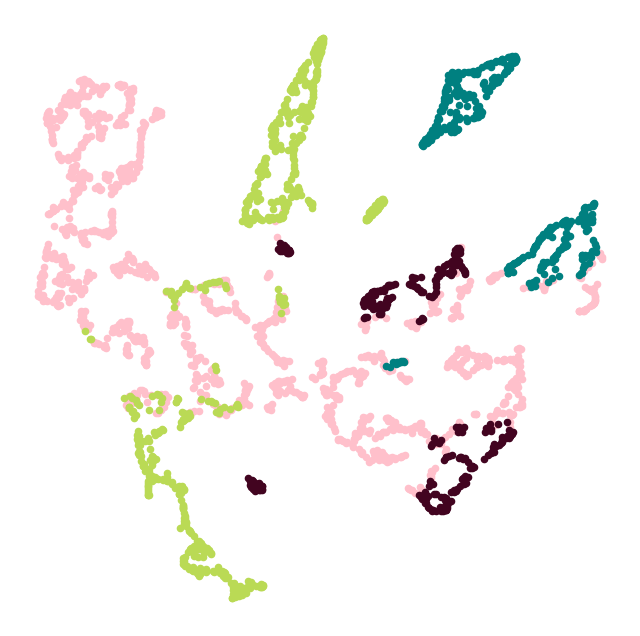

In [ ]:
@torch.no_grad()
def plot_points(colors):
    model.eval()
    z = model(torch.arange(data.num_nodes, device=device))
    z = TSNE(n_components=2).fit_transform(z.cpu().numpy())
    y = data.y.cpu().numpy()

    plt.figure(figsize=(8, 8))
    for i in range(4):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis('off')
    plt.show()

colors = [
    '#ffc0cb', '#bada55', '#008080', '#420420'
]
plot_points(colors)

In [ ]:
z = model(torch.arange(data.num_nodes, device=device))


tensor([[-0.2189,  0.7327,  0.1426,  ..., -0.2876, -0.3131, -0.1096],
        [ 0.1269, -0.0730,  0.1168,  ...,  0.0486,  0.2160, -0.0980],
        [-0.0049,  0.0867, -0.0193,  ..., -0.2901, -0.2607, -0.4507],
        ...,
        [-0.0191,  0.1300, -0.0314,  ..., -0.0593,  0.0436,  0.2019],
        [ 0.3026, -0.2631, -0.0091,  ...,  0.2362,  0.2464,  0.2426],
        [ 0.3301, -0.3298, -0.0630,  ...,  0.0643,  0.1354,  0.1623]],
       grad_fn=<IndexBackward0>)

In [ ]:
# Save node embeddings to a file
np.save('node_embeddings.npy', z.detach().numpy())
